In [1]:
'''
Author:		Hrag Najarian
Date:		August 2025
Purpose:	Act as a worksheet to analyze data from Chapter 3 of my dissertation which consists of
				investigating what is resulting in the intraseaonal change in the diurnal cycle over
				the ocean.
'''

'\nAuthor:\t\tHrag Najarian\nDate:\t\tAugust 2025\nPurpose:\tAct as a worksheet to analyze data from Chapter 3 of my dissertation which consists of\n\t\t\t\tinvestigating what is resulting in the intraseaonal change in the diurnal cycle over\n\t\t\t\tthe ocean.\n'

In [1]:
from wrf import getvar, ALL_TIMES, default_fill
import matplotlib as mpl
import cartopy.crs as ccrs
import glob
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import numpy as np
import xarray as xr
from flox.xarray import xarray_reduce
from flox import Aggregation
import os
import pandas as pd
import time
from math import cos, asin, sqrt, pi, atan, degrees, tan
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import label, sum as ndi_sum, distance_transform_edt

%matplotlib inline
%config InlineBackend.figure_format='retina'

### Function List

In [2]:
from scipy.ndimage import label, sum as ndi_sum, distance_transform_edt

def compute_coast_distance(da_landmask, min_cluster_size, dx_km):
    """
    Removes small land clusters from a LANDMASK and computes the signed distance from the coast.
    
    Parameters:
    -----------
    da_landmask : xarray.DataArray
        Binary landmask where 1 = land, 0 = ocean.
    min_cluster_size : int
        Minimum number of connected land points to retain as land.
        Multiply the min_cluster_size by dx_km^2 to get island area you are removing
    dx_km : float
        Grid spacing in kilometers for distance scaling.
    
    Returns:
    --------
    distance_from_coast : xarray.DataArray
        Distance from coast with land as negative values and ocean as positive values.
    """
    # Remove small land clusters
    matrix = da_landmask.values.copy()
    labeled_matrix, num_features = label(matrix)
    cluster_sizes = ndi_sum(matrix, labeled_matrix, index=np.arange(1, num_features + 1))

    for cluster_num, size in enumerate(cluster_sizes, start=1):
        if size < min_cluster_size:
            matrix[labeled_matrix == cluster_num] = 0

    # Update the landmask with filtered values, not including small clusters
    cleaned_landmask = da_landmask.copy(data=matrix)

    # Compute signed distance from the coast
    land_dist = distance_transform_edt(cleaned_landmask.values) * dx_km
    ocean_dist = distance_transform_edt((1 - cleaned_landmask.values)) * dx_km
    signed_distance = xr.where(cleaned_landmask == 1, -land_dist, ocean_dist)

    # Wrap result in DataArray with appropriate metadata
    dist_da = cleaned_landmask.copy(data=signed_distance)
    dist_da.name = 'DistFromCoast'
    dist_da.attrs['Units'] = 'km'
    dist_da.attrs['description'] = 'Negative for land, Positive for ocean'

    # Restore original coordinates
    dist_da = dist_da.assign_coords(
        south_north=('south_north', da_landmask.XLAT[:, 0].values),
        west_east=('west_east', da_landmask.XLONG[0, :].values)
    )

    # Create the bins for the distance from coast for groupby/xarray reduce functions
    dist_bins = np.arange(dist_da.values.min()-(dist_da.values.min()%dx_km), (dist_da.values.max()+(dx_km-(dist_da.values.max()%dx_km)))+dx_km, dx_km, dtype=int)
    dist_bins = dist_bins[dist_bins!=0]	# Remove 0 because no distance from coast value is == 0

    return dist_da, dist_bins

In [3]:
def group_and_average_by_distance(da, dist_bins, dim='distance_from_coast'):
    """
    Groups and averages an xarray object by binned distance from coast.

    Parameters:
    -----------
    da : xarray.DataArray or xarray.Dataset
        Input da to be grouped and averaged.
    dist_bins : array-like
        Bins to group the 'distance_from_coast' coordinate.
        Output from function compute_coast_distance
    dim : str, optional
        The coordinate name to bin and group by. Default is 'distance_from_coast'.

    Returns:
    --------
    xarray.DataArray or xarray.Dataset
        The grouped and averaged da with renamed bin coordinate.
    """
    ## Group by using flox
    grouped = xarray_reduce(da, dim, func='nanmean', expected_groups=dist_bins, isbin=[True], fill_value=np.nan)

    ## Assign bin left edges as coordinate
    grouped = grouped.assign_coords({f'{dim}_bins': pd.arrays.IntervalArray(grouped[f'{dim}_bins'].values).left.values})

    ## Rename bin coordinate to original dimension name
    return grouped.rename({f'{dim}_bins': dim})

In [4]:
def wind_direction(u, v):
    """
    Calculate wind direction from zonal and meridional wind components.
    
    Parameters:
    u (float or array-like): Zonal wind component (positive for eastward, negative for westward).
    v (float or array-like): Meridional wind component (positive for northward, negative for southward).
    
    Returns:
    float or ndarray: Wind direction in degrees (meteorological convention).
    """
	# Calculate wind direction in mathematical convention (counterclockwise from positive x-axis)
    # math_direction = np.degrees(np.arctan2(v, u))  # Convert radians to degrees

    # Convert to meteorological convention (clockwise from true north)
    direction = (180 + np.degrees(np.arctan2(-u, -v))) % 360
    return direction

In [5]:
# Assumes cartesian coordinate system
def calculate_angle_between_points(p1, p2):
    # Calculate differences
    dy = p2[0] - p1[0]  # Lats
    dx = p2[1] - p1[1]  # Lons
    # Find the angle (radians)
    theta = math.atan(dy/dx)
    
    return theta

# # Example points
# point1 = [0, 0]
# point2 = [1, 1]

# theta = math.degrees(calculate_angle_between_points(point1, point2))
# print(f"The angle between the points is {theta} degrees")

In [6]:
def vertical_cross_integration(da, p_bot, p_top):
	# Do a rolling mean to get the average between two pressure levels, remove the first level of da since it's nan's, and sel between two P levels
	da = da.rolling(bottom_top=2).mean().isel(bottom_top=slice(1,None)).sel(bottom_top=slice(p_bot,p_top))
	# Create dp and make it the same shape as da.
	dp_levels = da.bottom_top.diff(dim='bottom_top').expand_dims(dim={'Time':len(da.Time),'Distance':len(da.Distance),'Spread':len(da.Spread)})

	da_vertically_integrated = (da * dp_levels).sum('bottom_top') / (-9.81)

	return da_vertically_integrated

In [7]:
def round_to_two_significant_figures(number):
    """
    Rounds a float value to two significant figures using np.ceil or np.floor.

    Args:
        number (float): The input float value.

    Returns:
        float: The rounded value.
    """
    # Calculate the order of magnitude (power of 10) for the input number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))

    # Calculate the factor to round to two significant figures
    factor = 10**(2 - order_of_magnitude)

    # Round the number using np.ceil or np.floor
    rounded_value = np.ceil(number * factor) / factor

    return rounded_value

def round_to_one_significant_figures(number):
    """
    Rounds a float value to two significant figures using np.ceil or np.floor.

    Args:
        number (float): The input float value.

    Returns:
        float: The rounded value.
    """
    # Calculate the order of magnitude (power of 10) for the input number
    order_of_magnitude = np.floor(np.log10(np.abs(number)))

    # Calculate the factor to round to two significant figures
    factor = 10**(1 - order_of_magnitude)

    # Round the number using np.ceil or np.floor
    rounded_value = np.ceil(number * factor) / factor

    return rounded_value

round_to_one_significant_figures(0.00001427)

1.5e-05

In [8]:
# Linear Regression Function based on the scipy.stats.linregress function

# Make sure the x and y values are 1-D matrices

# Inclusion of custom start and end lag inputs. 
	# If you don't care for the negative lags, then start at 0, or vise versa.
	# This way you're not wasting resources on lags you don't need.

def linreg(x, y, min_lag, max_lag):
	# Initialize matrices
	slopes = []
	yintercepts = []
	rvalues = []
	pvalues = []
	stderrors = []
	# How to disypher what lag relationships mean:
		# Negative lag implies that x at the moment correlates with your y in the future
		# Positive lag implies that x at the moment correlates with you y in the past
	for lag in range(min_lag,max_lag+1):	# itterate from min_lag to max_lag (+1 because of range function)
		if lag == 0:	
			slope, yintercept, rvalue, pvalue, stderror = scipy.stats.linregress(x, y)
		elif lag < 0:
			slope, yintercept, rvalue, pvalue, stderror = scipy.stats.linregress(x[:lag], y[-lag:])
		elif lag > 0:
			slope, yintercept, rvalue, pvalue, stderror = scipy.stats.linregress(x[lag:], y[:-lag])
		
		# Append the values!
		slopes.append(slope)
		yintercepts.append(yintercept)
		rvalues.append(rvalue)
		pvalues.append(pvalue)
		stderrors.append(stderror)

	# Compile data into a dataarray for easy management
	da_reg = xr.DataArray(
		data=np.arange(min_lag,max_lag+1),
		dims='lag',
		coords=dict(
			slope = ('lag', slopes),
			yintercept = ('lag', yintercepts),
			rvalue = ('lag', rvalues),
			pvalue = ('lag', pvalues),
			stderror= ('lag',stderrors)
			),
		name='lin_reg'
		)

	return da_reg

In [9]:
# Calculate Temperature [K] via potential temperature equation [PT = T * (Po/P) ^ .286]
	# Link: https://glossary.ametsoc.org/wiki/Potential_temperature 
def theta_to_temp(theta):
	# PT = T * (P0/P)^(R/Cp)
		# PT = Potential temperature/theta
		# T = Temperature
		# P0 = 1000 hPa
		# P = Pressure
		# R = Gas constant for air (287.052874 J/(kg*K))
		# Cp = Specific heat capacity at constant pressure (1003.5 J/(kg*K))
			# R/Cp = 0.286
	# so
	# T = PT / (P0/P)^(0.286)
	temp = xr.zeros_like(theta)
	P = theta.bottom_top.values
	for i in range(len(P)):
		temp[:,i,...] = theta[:,i,...] / (1000/P[i])**(0.286)
	
	temp.name = 'Temperature'
	temp = temp.assign_attrs(Units='K')
	
	return temp

In [10]:
# Calculate Potential Temperature [K] via potential temperature equation [PT = T * (Po/P) ^ .286]
def temp_to_theta(temp, psfc):
	# PT = T * (P0/P)^(R/Cp)
		# PT = Potential temperature/theta
		# T = Temperature
		# P0 = 1000 hPa
		# P = Pressure
		# R = Gas constant for air (287.052874 J/(kg*K))
		# Cp = Specific heat capacity at constant pressure (1003.5 J/(kg*K))
			# R/Cp = 0.286
	
	theta = xr.zeros_like(temp)
	theta = temp* ((1000/psfc)**(0.286))

	theta.name = 'Potential Temperature'
	theta = theta.assign_attrs(Units='K')

	return theta


In [11]:
# Calculate Mixing Ratio [kg/kg]
def mixing_ratio(e):
	# Calculate mixing ratio
	# https://glossary.ametsoc.org/wiki/Mixing_ratio
	r = xr.zeros_like(e)
	P = e.bottom_top.values
	for i in range(len(P)):
		r[:,i,...] = 0.62197*((e[:,i,...])/(P[i]-e[:,i,...]))	# [kg/kg]
	
	r.name = 'Mixing Ratio'
	r = r.assign_attrs(Units='kg/kg')
	
	return r

In [12]:
# Calculate Virtual Temperature [K] via Tv = T(1+(rv/eps)) / (1+rv)
def virt_temp(T, rv, eps):
	# Calculate virtual temperature
	# https://glossary.ametsoc.org/wiki/Virtual_temperature
	Tv = xr.zeros_like(T)
	Tv = T*(1+(rv/eps)) / (1+rv)

	Tv.name = 'Virtual Temperature'
	Tv = Tv.assign_attrs(Units='K')

	return Tv

In [13]:
# Calculate Saturation Vapor Pressure 
def sat_vap_press(temperature):
	# Follow the Clausius-Clapeyron equation 
		# Link: https://geo.libretexts.org/Bookshelves/Meteorology_and_Climate_Science/Practical_Meteorology_(Stull)/04%3A_Water_Vapor/4.00%3A_Vapor_Pressure_at_Saturation
		# es = e0 * exp([L/Rv] * (1/T0 - 1/T))
	e0=6.113		# [hPa]
	Rv=461			# [J/(K*kg)]
	T0=273.15		# [K]
	Lv=2.5*(10**6)	# [J/kg]	# liquid water
	Ld=2.83*(10**6)	# [J/kg]	# ice water
	# Create matrix/dataarray da that has variable L values based on the 
		# temperature of the atmosphere where it changes based on if T < 0°C 
		# Divide by rv to create the constant L/Rv
	constant = temperature.where(temperature>273.15, Lv)/Rv
	constant = temperature.where(temperature<=273.15, Ld)/Rv

	es = e0 * np.exp(constant * ((1/T0)-(1/temperature)))

	es.name = 'Saturation Vapor Pressure'
	es = es.assign_attrs(Units='hPa')
	
	return es

In [14]:
def sat_mixing_ratio(es, psfc):
	# Calculate saturated mixing ratio
	# https://glossary.ametsoc.org/wiki/Mixing_ratio
	ws = xr.zeros_like(es)
	if 'bottom_top' in es.dims:
		P = es.bottom_top.values
		for i in range(len(P)):
			ws[:,i,...] = 0.62197*((es[:,i,...])/(P[i]-es[:,i,...]))	# [kg/kg]
	else:
		P = psfc
		ws = 0.62197*((es)/(P-es))	# [kg/kg]
	
	ws.name = 'Saturation Mixing Ratio'
	ws = ws.assign_attrs(Units='kg/kg')
	
	return ws

In [15]:
def rel_hum_theta(theta,w):
	# Calculate the relative humidity via observed potential temperature [K] and mixing ratio [kg/kg]
	temperature = theta_to_temp(theta)	# [K]
	es = sat_vap_press(temperature)		# [hPa]
	ws = sat_mixing_ratio(es,es.bottom_top.values)	# [kg/kg]
	RH = w/ws * 100						# [%]

	RH.name = 'Relative Humidity'
	RH = RH.assign_attrs(Units='%')

	return RH

In [16]:
def rel_hum_temp(temp,w,psfc):
	# Calculate the relative humidity via observed temperature [K] and mixing ratio [kg/kg]
	temperature = temp					# [K]
	es = sat_vap_press(temperature)		# [hPa]
	ws = sat_mixing_ratio(es,psfc)		# [kg/kg]
	RH = w/ws * 100						# [%]

	RH.name = 'Relative Humidity'
	RH = RH.assign_attrs(Units='%')

	return RH

In [17]:
# Purpose: To grab the indicies that correspond to the times, latitudes, and longitudes of the WRF dataset file.

# Input:
	# file == path to the .nc file
	# times == np.datetime64 array [Start,End]
	# lats == np.array [south,north]
	# lons == np.array [west,east]

# Output:
	# time_ind, lat_ind, lon_ind == corresponds to the indicies of the times, lats, and lons provided within that file

# Example:
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# isel_ind(file, times, lats, lons)

def isel_ind(file,times,lats,lons):
	# Declare the variables
	time_ind = np.zeros(2, dtype=int)
	lat_ind = np.zeros(2, dtype=int)
	lon_ind = np.zeros(2, dtype=int)
	# Open the file
	ds = xr.open_dataset(file)
	# Times
	time_vals = ds.XTIME.compute().values
	time_mask = (time_vals >= times[0]) & (time_vals <= times[1])
	time_indices = np.where(time_mask)[0]
	time_ind = [time_indices[0], time_indices[-1] + 1]  # +1 for Python slicing to include last index
	# Latitudes
	lat_vals = ds.XLAT[0,:,0].compute().values
	lat_mask = (lat_vals >= lats[0]) & (lat_vals <= lats[1])
	lat_indices = np.where(lat_mask)[0]
	lat_ind = [lat_indices[0], lat_indices[-1] + 1]  # +1 for Python slicing to include last index
	# Longitude
	lon_vals = ds.XLONG[0,0,:].compute().values
	lon_mask = (lon_vals >= lons[0]) & (lon_vals <= lons[1])
	lon_indices = np.where(lon_mask)[0]
	lon_ind = [lon_indices[0], lon_indices[-1] + 1]  # +1 for Python slicing to include last index


	return time_ind, lat_ind, lon_ind

In [18]:
# Purpose: Opens a dataset with restrictive bounds to make opening large files less intensive

# Input:
	# file == path to the .nc file
	# time_ind == indicies (inclusive) of the dates you want to look at
	# lat_ind == indicies (inclusive) of the latitudes you want to look at
	# lon_ind == indicies (inclusive) of the longitudes you want to look at

# Output:
	# ds == dataset that corresponds to the times, lats, and lons provided.

# Example:
	# To get the indicies, I suggest using the function isel_ind() I have coded up in tandem with this function (see above).
	# file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/raw/d01'
	# times = [np.datetime64('2015-11-22T12'), np.datetime64('2015-11-23T12')]
	# lats = [-7.5, 7.5]
	# lons = [90, 110]
	# time_ind, lat_ind, lon_ind = isel_ind(file, times, lats, lons)
	# ds = open_ds(file,time_ind,lat_ind,lon_ind)

def open_ds(file, time_ind, lat_ind, lon_ind):

	if time_ind[-1] == -1:
		ds = xr.open_dataset(file, chunks='auto').isel(
		Time=slice(None),
		# south_north=slice(lat_ind[0],lat_ind[1]),
		# west_east=slice(lon_ind[0],lon_ind[1])
		south_north=slice(None),
		west_east=slice(None)
	)
	else:
		ds = xr.open_dataset(file, chunks='auto').isel(
			Time=slice(time_ind[0],time_ind[1]),
			south_north=slice(lat_ind[0],lat_ind[1]),
			west_east=slice(lon_ind[0],lon_ind[1])
		)
	
	return ds

In [19]:
# This function finds the distance [km] between two coordinates in lat & lon. 
    # If your map projection is Mercator (check 'MAP_PROJ'), then this works. 
    # If Lambert, then you need to do conversions, look at ChatGPT logs ('Distance Calculation Approximation')
def dist(lat1, lon1, lat2, lon2):
    r = 6371 # km
    p = pi / 180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))


In [20]:
# Purpose: Rotate a vectorized variable like a wind vector in x/lon and y/lat space!
	# See Lecture02_Vector.pdf in METR 5113 Advanced Atmospheric Dynamics folder

# Input:
    # da_x  = 		xr.data_array		 	# Should be the X component of the vector
    # da_y  = 		xr.data_array			# Should be the Y component of the vector
		# Can be one time step or pressure level or even a 4-D variable [Time x Height x Lat x Lon]
    # theta =		rotation in radians		
		# Must be -pi/2 < theta < pi/2, you don't need to rotate any more than the 180° provided
		# Positive theta indiates anticlockwise turn of coordinates
		# Negative theta indiates clockwise turn of coordinates
# Output:
    # da_x_rot:		da_x but rotated
	# da_y_rot:		da_y but rotated
# Process:
    # Check if theta is positive or negative
		# Based on the value, the projections using theta will change
	# Project the current x and y coordinate to the new rotated x and y coordinates for each component.
	# Once rotated, return the rotated x and y components

def rotate_vec(da_x, da_y, theta):
	# anti-clockwise rotation
	if (theta > 0) & (theta<pi/2):
		da_x_rot = da_x*cos(theta) + da_y*cos((pi/2)-theta)
		da_y_rot = -da_x*cos((pi/2)-theta) + da_y*cos(theta)
	# clockwise rotation
	if (theta < 0) & (theta>(-pi/2)):
		da_x_rot = da_x*cos(-theta) - da_y*cos((pi/2)+theta)
		da_y_rot = da_x*cos((pi/2)+theta) + da_y*cos(-theta)

	return da_x_rot, da_y_rot

In [21]:
# Purpose: Create an array with multiple cross-sectional data from WRFoutput.
# Input:
    # da = 			xr.data_array		 	works with both 2-D and 3-D variables!
    # start_coord = [latitude, longitude] 
    # end_coord = 	[latitude, longitude]
	# width = 		spread of cross-section in degrees i.e., 0.75° = 0.75
	# dx = 			distance between each cross-sectional line i.e., 0.05° = 0.05
# Output:
    # da_cross: 		matrix in time, height, distance, and # of lines
		# 					or time, distance, and # of lines if using a 2-D variable
	# all_line_coords:	
# Process:
	# Make sure you 'da' have assigned coordinates corresponding to south_north and west_east.
    # We first create a main line between start_coord -> end_coord. This line will be the center
		# line for all other lines to sit next to.
	# Depending on the angle of the line (more latitudinal change or longitudinal change), this
		# function will account for that and make the longest side the length of the cross-sectional line
	# We then create an empty np.array, calculate the change in spread needed, then start filling in the data.

def cross_section_multi(da, start_coord, end_coord, width, dx):

	# We want to first create a line between start and end_coords
		# Gather the indicies of the closest gridboxes of start and end_coords.
	start_ilat = int((abs((da.XLAT[0,:,0]) - (start_coord[0]))).argmin())
	end_ilat = int((abs((da.XLAT[0,:,0]) - (end_coord[0]))).argmin())
	start_ilon = int((abs((da.XLONG[0,0,:]) - (start_coord[1]))).argmin())
	end_ilon = int((abs((da.XLONG[0,0,:]) - (end_coord[1]))).argmin())
	# This statement ensures that the length of the line will be the size of the LONGEST side (either lat or lon)
	if abs(start_ilat-end_ilat)>=abs(start_ilon-end_ilon):
		line_coords = np.zeros([2,abs(start_ilat-end_ilat)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilat-end_ilat))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilat-end_ilat))
	else:
		line_coords = np.zeros([2,abs(start_ilon-end_ilon)])
		# Populate latitudes
		line_coords[0,:] = np.linspace(da.XLAT[0,start_ilat,0], da.XLAT[0,end_ilat,0], abs(start_ilon-end_ilon))
		# Populate longitudes
		line_coords[1,:] = np.linspace(da.XLONG[0,0,start_ilon], da.XLONG[0,0,end_ilon], abs(start_ilon-end_ilon))

	##########################################################################################################################
	# Now that we have the coordinates between the start and end_coords, we need to replicate it for all the lines
	num_lines = int(width/dx)
	spread = np.arange(width/2,-width/2,-dx)
	if 'bottom_top' in da.dims:	# If the dataset is 3-D
		#						TIME	x	HEIGHT	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],da.shape[1],line_coords.shape[1],num_lines])
	else:
		#						TIME	x	   DISTANCE	   x   #ofLINES
		da_cross = np.zeros([da.shape[0],line_coords.shape[1],num_lines])

	# Create all_line_coords that holds all the coordinates for every line produced
	all_line_coords = np.zeros([line_coords.shape[0],line_coords.shape[1],spread.shape[0]])

	# Looping over all the lines
	for i in range(len(spread)):
		
		# Fix this part
		if (end_coord[0] > start_coord[0]):
			all_line_coords[0,:,i] = line_coords[0,:]+spread[i]
		else:
			all_line_coords[0,:,i] = line_coords[0,:]-spread[i]
		if (end_coord[1] > start_coord[1]):
			all_line_coords[1,:,i] = line_coords[1,:]-spread[i]
		else:
			all_line_coords[1,:,i] = line_coords[1,:]+spread[i]

		# Now that we have our lines, we can interpolate the dataset with the offset for each line applied
		da_interp = da.interp(south_north=all_line_coords[0,:,i], west_east=all_line_coords[1,:,i], method="linear")

		# Populate the new data array with data from the cross section
			# Loop through the length of the line, find the match, and then populate it.
		if 'bottom_top' in da.dims:	# If the dataset is 3-D
			for j in range(da_cross.shape[2]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,:,j,i] = data
		else:
			for j in range(da_cross.shape[1]):
				data = da_interp.sel(
					south_north = da_interp.south_north[j],
					west_east = da_interp.west_east[j])
				da_cross[:,j,i] = data

	return da_cross, all_line_coords

In [22]:
# Purpose: Create a LocalTime coordinate within your DataArray.

# Input:
    # da = xr.DataArray;  Must be in shape: time x south_north x west_east
		# Make sure west_east/XLONG values are 0->360, not -180->+180
	# dim_num = 2 or 3;  This indicates to the function if you want Local Time
		# within the dataarray to be only a function of time and longitude, or
		# time, lognitude, and latitude. This is a preference and if you don't need
		# it as a function of latitude, it will save lots of time going with dim_num = 2.
# Output:
    # da: This will be the DataArray with the newly assigned coordinate
# Process:
    # First create a matrix of hours to be offset relative to UTC.
    # Create an empty array that has dimensions Time and Longitude.
    # Loop through each timestep and longitude to determine the local time.
    # Assign the new Local Time coordinate to the da and return it.


def assign_LT_coord(da, dim_num):
	hour_offset = (da.XLONG.values[:,0,:]/15).round(decimals=0)

	# Local Time is a function of only Time and Longitude
	if dim_num==2:
		local_time = np.empty([len(da.Time),len(da.west_east)], dtype=object)
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[1]):
				local_time[i,j] = da.Time.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
		da = da.assign_coords(LocalTime=(('Time','west_east'),local_time))
	
	# Local Time is a function of Time, Longitude, and Latitude
	else:
		local_time = np.empty([len(da.Time),len(da.south_north),len(da.west_east)], dtype='datetime64[ns]')
		for i in range(local_time.shape[0]):
			for j in range(local_time.shape[2]):
				local_time[i,:,j] = da.Time.values[i] + np.timedelta64(int(hour_offset[0,j]),'h')
		da = da.assign_coords(LocalTime=(('Time','south_north','west_east'),local_time))
	return da


In [23]:
# Assumes cartesian/flat coordinate system
def calculate_angle_between_points(p1, p2):
    # Calculate differences
    dy = p2[0] - p1[0]  # Lats
    dx = p2[1] - p1[1]  # Lons
    # Find the angle (radians)
    theta = atan(dy/dx)

    # Negative if NW or SE direction
    # Positive if NE or SW direction
    
    return theta

# start_coord		= [1.2,112.8]
# end_coord 		= [5.2,108.8]
# degrees(calculate_angle_between_points(start_coord, end_coord))

In [24]:
# Makes making tick labels easier
# ticks are integers
def degree_labels(ticks, lat_or_lon):

	labels = []
	
	if lat_or_lon=='lat':
		for t in ticks:
			if t >= 0:
				labels.append(str(t)+u'\N{DEGREE SIGN}N')
			else:
				labels.append(str(t)+u'\N{DEGREE SIGN}S')
				
	elif lat_or_lon=='lon':
		for t in ticks:
			if t >= 0:
				labels.append(str(t)+u'\N{DEGREE SIGN}E')
			else:
				labels.append(str(t)+u'\N{DEGREE SIGN}W')
	return labels

## Load Data

In [25]:
def build_path(parent_dir: str, sub_dir: str, name: str) -> str:
    return f"{parent_dir}/{sub_dir}/{name}"

def load_variable(file_dict: dict, coords: dict, is_diff: bool) -> xr.DataArray:
    step_start = time.perf_counter()
    # If its a difference of already sliced datasets, don't slice further
    if is_diff:
        # ds = open_ds(file_dict['path'], [0,-1], lat_ind_d02, lon_ind_d02)
        ds = open_ds(file_dict['path'], [0,-1], [0,-1], [0,-1])
    else:
        ds = open_ds(file_dict['path'], time_ind_d02, lat_ind_d02, lon_ind_d02)
        
    da = ds[file_dict['varname']].compute()
    da = da.assign_coords(coords)
    # Replace fill value with nan
    da = da.where(da != default_fill(np.float32))
    print(f"{file_dict['description']} loaded ✓", time.perf_counter() - step_start, "seconds")
    return da

# Function that can removes the bottom_top dimension for 2-D datasets
def without_keys(d, keys):
	return {x: d[x] for x in d if x not in keys}

In [26]:
def diff_load_or_save(file_diff:dict, files_1:dict, files_2:dict, coords:dict, file_1_and_2_diff:bool):
	
	"""
    Load a difference DataArray from disk if it exists; otherwise, compute the difference from two input files,
    remove coordinates to reduce file size, save it, and return the result with desired coordinates.

    Parameters
    ----------
    file_diff : dict
        Dictionary with keys including 'path', 'varname', and 'description' for the output difference file.
    files_1 : dict
        Dictionary containing metadata and path info for the first input file.
    files_2 : dict
        Dictionary containing metadata and path info for the second input file.
    coords : dict
        Dictionary of coordinates to assign to the returned DataArray.
    file_1_and_2_diff : bool
        If True, treats `files_1` and `files_2` as already pre-computed differences (disables additional slicing).

    Returns
    -------
    xarray.DataArray
        The difference DataArray WITH coordinates assigned but not saved in the output file.
    """

	directory = os.path.dirname(file_diff['path'])
	files = [os.path.join(directory, f) for f in os.listdir(directory)]
	
	# If the file exists, just load it up
	if file_diff['path'] in files:
		da_diff = load_variable(file_diff, coords, is_diff=True)
	# Compute it and save it if it doesn't exist
	else:
		if file_1_and_2_diff:	# If files 1 and 2 are already differences, don't slice
			da_1 = load_variable(files_1, coords, is_diff=True)
			da_2 = load_variable(files_2, coords, is_diff=True)
		else:
			da_1 = load_variable(files_1, coords, is_diff=False)
			da_2 = load_variable(files_2, coords, is_diff=False)
		
		step_start = time.perf_counter()
		# Take difference
		da_diff = da_1 - da_2
		# Update variable name and description
		da_diff.name = file_diff['varname']
		da_diff.attrs['description'] = file_diff['description']

		# Create a new DataArray with the same data and dims, but no coords (saves 3-times the storage space + load times)
		da_diff_stripped = xr.DataArray(
			data=da_diff.data,
			dims=da_diff.dims,
			name=da_diff.name,
			attrs=da_diff.attrs
		)

		# Save File
		da_diff_stripped.to_netcdf(path=file_diff['path'], mode='w', format='NETCDF4', unlimited_dims='Time', compute=True)
		
		print(f"{file_diff['description']} loaded ✓", time.perf_counter() - step_start, "seconds")

	return da_diff.assign_coords(coords)

### Spatial Data

#### Control Data
This section opens stitched wrfout .nc files. The raw .nc file is much to large, so I have extracted variables from the large file into smaller .nc files that only contains one variable. To get these smaller .nc files, please refer to extract_variable.py and interp_variable.py function I have created. This section opens those files up and assigned them to a variable.

* 10.5-day (2015 11-22-12UTC -> 2015 12-03-00UTC)
* 10.5-day (2015 12-09-12UTC -> 2015 12-20-00UTC)

Below the section where I assigned file names, there is an option for you to only open up a smaller domain (spatial and temporal) if you are interetsed in a select region (helpful for debugging). This will save you a lot of computational time.

__Adjusted LH__

Adjusted LH (Surface Latent Heat Release) is an experiment conducted on the CTRL simulation that adjusts the LH in WRF to be similar to the LH during the timeperiod of the opposite MJO phase of the CTRL. For example, if the CTRL time period is during the PreMJO, the adjLH simulation will take place in the PreMJO time period with the LH adjusted to correspond to the MJO time period.

In [40]:
start_time = time.perf_counter()

## Select Parent Directory:
# times = [np.datetime64('2015-12-10T01'), np.datetime64('2015-12-10T02')]  # Used to debug

# times = [np.datetime64('2015-11-23T01'), np.datetime64('2015-12-02T00')]
# parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00'
# parent_dir_adjLH = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/adjLH'

times = [np.datetime64('2015-12-10T01'), np.datetime64('2015-12-20T00')]
parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00'
# parent_dir_adjLH = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00/adjLH'
parent_dir_swap_rh = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00/swap_rh'


## Create Dictionary with file names, units, description.

    # 2-D data
l1_files = {
    'd02_LowCLDFRA':     ('0-1',      'CLDFRA',   'Low-level cloud fraction'),
    'd02_MidCLDFRA':     ('0-1',      'CLDFRA',   'Mid-level cloud fraction'),
    'd02_HighCLDFRA':    ('0-1',      'CLDFRA',   'High-level cloud fraction'),
    'd02_HFX':           ('W/m^2',    'HFX',      'Surface sensible heat flux'),
    'd02_LH':            ('W/m^2',    'LH',       'Surface latent heat flux'),
    'd02_SMOIS':         ('kg^3/kg^3','SMOIS',    'Soil moisture'),
    'd02_RR':            ('mm/dt',    'RR',       'Rain rate'),
    'd02_U10':           ('m/s',      'U10',      '10-meter U-wind'),
    'd02_V10':           ('m/s',      'V10',      '10-meter V-wind'),
	'd02_SSTSK':         ('K',        'SSTSK',    'Sea surface temperature'),
    'd02_T2':            ('K',        'T2',       '2-meter temperature'),
    'd02_TSK':           ('K',        'TSK',      'Surface skin temperature'),
    'd02_PSFC':          ('hPa',      'PSFC',     'Surface pressure'),
    'd02_Q2':            ('kg/kg',    'Q2',       '2-meter specific humidity'),
    'd02_VEGFRA':        ('0-1',      'VEGFRA',   'Vegetation fraction'),
    'd02_CAPE':          ('J/kg',     'CAPE',     'Convective Available Potential Energy'),
    'd02_CIN':           ('J/kg',     'CIN',      'Convective Inhibition'),
    'd02_LWDNB':         ('W/m^2',    'LWDNB',    'SFC Downward longwave radiation'),
    'd02_LWUPB':         ('W/m^2',    'LWUPB',    'SFC Upward longwave radiation'),
    'd02_LWDNBC':        ('W/m^2',    'LWDNBC',   'SFC Clear-sky downward longwave radiation'),
    'd02_LWUPBC':        ('W/m^2',    'LWUPBC',   'SFC Clear-sky upward longwave radiation'),
    'd02_SWDNB':         ('W/m^2',    'SWDNB',    'SFC Downward shortwave radiation'),
    'd02_SWUPB':         ('W/m^2',    'SWUPB',    'SFC Upward shortwave radiation'),
    'd02_SWDNBC':        ('W/m^2',    'SWDNBC',   'SFC Clear-sky downward SW radiation'),
    'd02_SWUPBC':        ('W/m^2',    'SWUPBC',   'SFC Clear-sky upward SW radiation'),
    'd02_LWDNT':         ('W/m^2',    'LWDNT',    'TOA Downward longwave radiation'),
    'd02_LWUPT':         ('W/m^2',    'LWUPT',    'TOA Upward longwave radiation'),
    'd02_LWDNTC':        ('W/m^2',    'LWDNTC',   'TOA Clear-sky downward longwave radiation'),
    'd02_LWUPTC':        ('W/m^2',    'LWUPTC',   'TOA Clear-sky upward longwave radiation'),
    'd02_SWDNT':         ('W/m^2',    'SWDNT',    'TOA Downward shortwave radiation'),
    'd02_SWUPT':         ('W/m^2',    'SWUPT',    'TOA Upward shortwave radiation'),
    'd02_SWDNTC':        ('W/m^2',    'SWDNTC',   'TOA Clear-sky downward SW radiation'),
    'd02_SWUPTC':        ('W/m^2',    'SWUPTC',   'TOA Clear-sky upward SW radiation'),
	# Differences in rad
    'd02_LWSFC':         ('W/m^2',    'LWSFC',        'LWDNB - LWUPB'),
    'd02_LWSFC_Clear':   ('W/m^2',    'LWSFC_Clear',  'LWDNBC - LWUPBC'),
    'd02_SWSFC':         ('W/m^2',    'SWSFC',        'SWDNB - SWUPB'),
    'd02_SWSFC_Clear':   ('W/m^2',    'SWSFC_Clear',  'SWDNBC - SWUPBC'),
	
	'd02_LWATM':         ('W/m^2',    '__xarray_dataarray_variable__',        '(LWDNT-LWUPT) + (LWUPB-LWDNB)'),
    'd02_LWATM_Clear':   ('W/m^2',    '__xarray_dataarray_variable__',  '(LWDNTC-LWUPTC) + (LWUPBC-LWDNBC)'),
    'd02_LWATM_CRF':     ('W/m^2',    '__xarray_dataarray_variable__',    'LWATM-LWATM_Clear'),
	
    'd02_SWATM':         ('W/m^2',    '__xarray_dataarray_variable__',        '(SWDNT-SWUPT) + (SWUPB-SWDNB)'),
    'd02_SWATM_Clear':   ('W/m^2',    '__xarray_dataarray_variable__',  '(SWDNTC-SWUPTC) + (SWUPBC-SWDNBC)'),
    'd02_SWATM_CRF':     ('W/m^2',    '__xarray_dataarray_variable__',    'SWATM-SWATM_Clear'),
}
    # Interpolated 3-D data 
l2_files = {
    'd02_interp_U':         ('m/s',     'U',         'Interpolated U-wind'),
    'd02_interp_V':         ('m/s',     'V',         'Interpolated V-wind'),
    'd02_interp_W':         ('m/s',     'W',         'Interpolated W-wind'),
    'd02_interp_QV':        ('kg/kg',   'QV',        'Interpolated specific humidity'),
    'd02_interp_CLDFRA':    ('0-1',     'CLDFRA',    'Interpolated cloud fraction'),
    'd02_interp_H_DIABATIC':('K/s',     'H_DIABATIC','Interpolated diabatic heating'),
    'd02_interp_Theta':     ('K',       'Theta',     'Interpolated potential temperature'),
    'd02_interp_LWAll':     ('K/s',     'LWAll',     'Interpolated longwave heating (all-sky)'),
    'd02_interp_LWClear':   ('K/s',     'LWClear',   'Interpolated longwave heating (clear-sky)'),
    'd02_interp_SWAll':     ('K/s',     'SWAll',     'Interpolated shortwave heating (all-sky)'),
    'd02_interp_SWClear':   ('K/s',     'SWClear',   'Interpolated shortwave heating (clear-sky)'),
}
    # Vertically integrated 3-D data
l4_files = {
    'd02_VI_W_1000-100':             ('kg/ms',     'W',         'Vertically Integrated Vertical Winds'),
    'd02_VI_W_1000-500':             ('kg/ms',     'W',         'Vertically Integrated Vertical Winds'),
    'd02_VI_W_1000-700':             ('kg/ms',     'W',         'Vertically Integrated Vertical Winds'),
    'd02_VI_W_500-200':              ('kg/ms',     'W',         'Vertically Integrated Vertical Winds'),
    'd02_VI_QV_1000-100':            ('kg/m^2',    'QV',        'Vertically Integrated Water Vapor'),
    'd02_VI_QV_1000-500':            ('kg/m^2',    'QV',        'Vertically Integrated Water Vapor'),
    'd02_VI_QV_1000-700':            ('kg/m^2',    'QV',        'Vertically Integrated Water Vapor'),
    'd02_VI_QV_1000-800':            ('kg/m^2',    'QV',        'Vertically Integrated Water Vapor')
}
# Build structured dictionary
files = {
    'L1': {
        var: {
            "path": build_path(parent_dir_CTRL, 'L1', var),
            "unit": unit,
			"varname": varname,
            "description": desc
        }
        for var, (unit, varname, desc) in l1_files.items()
    },
    'L2': {
        var: {
            "path": build_path(parent_dir_CTRL, 'L2', var),
            "unit": unit,
            "varname": varname,
            "description": desc
        }
        for var, (unit, varname, desc) in l2_files.items()
    },
    'L4': {
        var: {
            "path": build_path(parent_dir_CTRL, 'L4', var),
            "unit": unit,
			"varname": varname,
            "description": desc
        }
        for var, (unit, varname, desc) in l4_files.items()
    }
}


######################################################################################
################ Declare the bounds you want to specifically look at #################
######################################################################################


lats = [-10, 10]
lons = [80, 135]
interp_P_levels = np.concatenate((np.arange(1000,950,-10),np.arange(950,350,-30),np.arange(350,0,-50)))

######################################################################################
######################################################################################
######################################################################################

# Setup the indicies that will be used throughout
time_ind_d01, lat_ind_d01, lon_ind_d01 = isel_ind(build_path(parent_dir_CTRL, "raw", "d01"), times, lats, lons)
time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(build_path(parent_dir_CTRL, "raw", "d02"), times, lats, lons)

## Raw datasets
ds_d01 = open_ds(build_path(parent_dir_CTRL, "raw", "d01"),time_ind_d01,lat_ind_d01,lon_ind_d01)
ds_d02 = open_ds(build_path(parent_dir_CTRL, "raw", "d02"),time_ind_d02,lat_ind_d02,lon_ind_d02)
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# Coordinate dictionaries:
step2_time = time.perf_counter()

# d01_coords = dict(
#     XLAT=(('Time','south_north','west_east'),ds_d01.XLAT.values),
#     XLONG=(('Time','south_north','west_east'),ds_d01.XLONG.values),
#     bottom_top=(('bottom_top'),interp_P_levels),
#     Time=('Time',ds_d01.XTIME.values),
#     south_north=(('south_north'),ds_d01.XLAT[0,:,0].values),
#     west_east=(('west_east'),ds_d01.XLONG[0,0,:].values)
#     )

file_path_coords = build_path(parent_dir_CTRL,'raw','d02_coords')
file_path_static_coords = build_path(parent_dir_CTRL,'raw','d02_static_coords')
if file_path_coords not in glob.glob(os.path.dirname(file_path_coords) + '/*'):
    d02_coords = dict(
        XLAT=(('Time','south_north','west_east'),ds_d02.XLAT.values),
        XLONG=(('Time','south_north','west_east'),ds_d02.XLONG.values),
        bottom_top=(('bottom_top'),interp_P_levels),
        Time=('Time',ds_d02.XTIME.values),
        south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
        west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
        )
    ## No time or bottom_top dimensions
    d02_static_coords = dict(
        XLAT=(('south_north','west_east'),ds_d02.XLAT[0].values),
        XLONG=(('south_north','west_east'),ds_d02.XLONG[0].values),
        south_north=(('south_north'),ds_d02.XLAT[0,:,0].values),
        west_east=(('west_east'),ds_d02.XLONG[0,0,:].values)
        )
    ## Save coordinates so you can just load them in
    ds_coords = xr.Dataset(coords=d02_coords)
    ds_coords.to_netcdf(file_path_coords)
    ds_static_coords = xr.Dataset(coords=d02_static_coords)
    ds_static_coords.to_netcdf(file_path_static_coords)
## Open coord files
ds_coords = xr.open_dataset(file_path_coords)
d02_coords = {
    var: (ds_coords[var].dims, ds_coords[var].values)
    for var in ds_coords.coords}
ds_static_coords = xr.open_dataset(file_path_static_coords)
d02_static_coords = {
    var: (ds_static_coords[var].dims, ds_static_coords[var].values)
    for var in ds_static_coords.coords}

step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')



###########################################################
################# Load in the variables ###################
##################### 3-D variables #######################
# da_d02_U = load_variable(files['L2']['d02_interp_U'], d02_coords, False)
# da_d02_V = load_variable(files['L2']['d02_interp_V'], d02_coords, False)
# da_d02_W = load_variable(files['L2']['d02_interp_W'], d02_coords, False)
# da_d02_QV = load_variable(files['L2']['d02_interp_QV'], d02_coords, False)
# da_d02_CLDFRA = load_variable(files['L2']['d02_interp_CLDFRA'], d02_coords, False)
# da_d02_H_DIABATIC = load_variable(files['L2']['d02_interp_H_DIABATIC'], d02_coords, False)
# da_d02_Theta = load_variable(files['L2']['d02_interp_Theta'], d02_coords, False)
# da_d02_LWAll = load_variable(files['L2']['d02_interp_LWAll'], d02_coords, False)
# da_d02_LWClear = load_variable(files['L2']['d02_interp_LWClear'], d02_coords, False)
# da_d02_SWAll = load_variable(files['L2']['d02_interp_SWAll'], d02_coords, False)
# da_d02_SWClear = load_variable(files['L2']['d02_interp_SWClear'], d02_coords, False)
# ##Cloud-Radiative Forcing Calculations ##
# da_d02_LWCRF = da_d02_LWAll - da_d02_LWClear	# Longwave
# da_d02_SWCRF = da_d02_SWAll - da_d02_SWClear	# Shortwave
# da_d02_TotalCRF = da_d02_LWCRF + da_d02_SWCRF	# Total

###########################################################
##################### 2-D variables #######################
da_d02_RR = load_variable(files['L1']['d02_RR'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_LowCLDFRA = load_variable(files['L1']['d02_LowCLDFRA'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_MidCLDFRA = load_variable(files['L1']['d02_MidCLDFRA'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_HighCLDFRA = load_variable(files['L1']['d02_HighCLDFRA'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_HFX = load_variable(files['L1']['d02_HFX'], without_keys(d02_coords, 'bottom_top'), False)
da_d02_LH = load_variable(files['L1']['d02_LH'], without_keys(d02_coords, 'bottom_top'), False)
da_d02_U10 = load_variable(files['L1']['d02_U10'], without_keys(d02_coords, 'bottom_top'), False)
da_d02_V10 = load_variable(files['L1']['d02_V10'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_SMOIS = load_variable(files['L1']['d02_SMOIS'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_VEGFRA = load_variable(files['L1']['d02_VEGFRA'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_SSTSK = load_variable(files['L1']['d02_SSTSK'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_T2 = load_variable(files['L1']['d02_T2'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_TSK = load_variable(files['L1']['d02_TSK'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_PSFC = load_variable(files['L1']['d02_PSFC'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_Q2 = load_variable(files['L1']['d02_Q2'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_CAPE = load_variable(files['L1']['d02_CAPE'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_CIN = load_variable(files['L1']['d02_CIN'], without_keys(d02_coords, 'bottom_top'), False)
# ## Extra Variable Calculations
# da_d02_QS2 = sat_mixing_ratio(sat_vap_press(da_d02_T2),da_d02_PSFC)
# da_d02_RH2 = rel_hum_temp(da_d02_T2, da_d02_Q2, da_d02_PSFC)	# Calculates relative humidty (%) using temperature and q at surface
da_d02_Uwind10 = (da_d02_U10**2+da_d02_V10**2)**.5
# da_d02_Udir10 = wind_direction(da_d02_U10, da_d02_V10)

## Vertically Integrated
    # Vertical Wind
    # Add negative to W so upward motion is positive
# da_d02_VI_W_1000_100 = -load_variable(files['L4']['d02_VI_W_1000-100'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_VI_W_1000_500 = -load_variable(files['L4']['d02_VI_W_1000-500'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_VI_W_1000_700 = -load_variable(files['L4']['d02_VI_W_1000-700'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_VI_W_500_200 = -load_variable(files['L4']['d02_VI_W_500-200'], without_keys(d02_coords, 'bottom_top'), False)
#     # Water Vapor
da_d02_VI_QV_1000_100 = -load_variable(files['L4']['d02_VI_QV_1000-100'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_VI_QV_1000_500 = -load_variable(files['L4']['d02_VI_QV_1000-500'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_VI_QV_1000_700 = -load_variable(files['L4']['d02_VI_QV_1000-700'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_VI_QV_1000_800 = -load_variable(files['L4']['d02_VI_QV_1000-800'], without_keys(d02_coords, 'bottom_top'), False)

## Surface
# da_d02_LWSFC = diff_load_or_save({'path':build_path(parent_dir_CTRL, 'L1', 'd02_LWSFC'), 'varname':'LWSFC', 'description':'LWDNB - LWUPB'},
# 				   files['L1']['d02_LWDNB'], files['L1']['d02_LWUPB'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=False)
# da_d02_LWSFC_Clear = diff_load_or_save({'path':build_path(parent_dir_CTRL, 'L1', 'd02_LWSFC_Clear'), 'varname':'LWSFC_Clear', 'description':'LWDNBC - LWUPBC'},
# 				   files['L1']['d02_LWDNBC'], files['L1']['d02_LWUPBC'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=False)
# da_d02_LWSFC_CRF = diff_load_or_save({'path':build_path(parent_dir_CTRL, 'L1', 'd02_LWSFC_CRF'), 'varname':'LWSFC_CRF', 'description':'LWSFC - LWSFC_Clear'},
# 				   files['L1']['d02_LWSFC'], files['L1']['d02_LWSFC_Clear'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=True)

# da_d02_SWSFC = diff_load_or_save({'path':build_path(parent_dir_CTRL, 'L1', 'd02_SWSFC'), 'varname':'SWSFC', 'description':'SWDNB - SWUPB'},
# 				   files['L1']['d02_SWDNB'], files['L1']['d02_SWUPB'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=False)
# da_d02_SWSFC_Clear = diff_load_or_save({'path':build_path(parent_dir_CTRL, 'L1', 'd02_SWSFC_Clear'), 'varname':'SWSFC_Clear', 'description':'SWDNBC - SWUPBC'},
# 				   files['L1']['d02_SWDNBC'], files['L1']['d02_SWUPBC'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=False)
# da_d02_SWSFC_CRF = diff_load_or_save({'path':build_path(parent_dir_CTRL, 'L1', 'd02_SWSFC_CRF'), 'varname':'SWSFC_CRF', 'description':'SWSFC - SWSFC_Clear'},
# 				   files['L1']['d02_SWSFC'], files['L1']['d02_SWSFC_Clear'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=True)

da_d02_LAKEMASK = ds_d02['LAKEMASK'].sel(Time=slice(1)).compute().squeeze()     # Lake = 1, Non-lake = 0
da_d02_LANDMASK = ds_d02['LANDMASK'].sel(Time=slice(1)).compute().squeeze()     # Land = 1, Water = 0
# Update LANDMASK to mask lakes into land
da_d02_LANDMASK = xr.where((da_d02_LAKEMASK==1), 1, da_d02_LANDMASK)            # If lake (1), change landmask of 0 to land (1).
da_d02_LANDMASK = da_d02_LANDMASK.assign_coords(d02_static_coords)

da_d02_TOPO = ds_d02['HGT'].sel(Time=slice(1)).compute().squeeze().assign_coords(d02_static_coords)

# x = da_d02_LANDMASK.copy().isel(south_north=slice(int((abs(da_d02_LANDMASK.XLAT[:,0]+10)).argmin()),int((abs(da_d02_LANDMASK.XLAT[:,0]-5)).argmin())))
# print(f'Land/Ocean Ratio: {((x==1).sum()/(x==0).sum()).values}')

dx_km = 3
min_cluster_size = 600		# 1500 for only large islands, 100 for getting rid of small islands, 600 for getting rid of medium islands
da_distance_from_coast, dist_bins = compute_coast_distance(da_d02_LANDMASK, min_cluster_size, dx_km)

print('CTRL data loaded \N{check mark}', time.perf_counter()-start_time, 'seconds')

Dataset loaded ✓ 1.0329747020150535 seconds
Created coordinate dictionaries ✓ 0.9499603639997076 seconds
Rain rate loaded ✓ 1.8583693240070716 seconds
Surface latent heat flux loaded ✓ 1.8690141639963258 seconds
10-meter U-wind loaded ✓ 1.8612042249878868 seconds
10-meter V-wind loaded ✓ 1.849859980022302 seconds
Vertically Integrated Water Vapor loaded ✓ 1.8716102280013729 seconds
CTRL data loaded ✓ 13.840317435999168 seconds


#### Swapped RH Data

In [43]:
start_time = time.perf_counter()

# Create new dictionary with 'swap' inserted into variable names
files_swap = {
    level: {
        var.replace('d02_', 'd02_swap_'): {
            'path': build_path(parent_dir_swap_rh, level, var.replace('d02_', 'd02_swap_')),
            'unit': props['unit'],
            'varname': props['varname'],
            'description': props['description']
        }
        for var, props in level_dict.items()
        if var.startswith('d02_')  # Only modify variables that start with 'd02_'
    }
    for level, level_dict in files.items()
}

## Setup the indicies that will be used throughout
time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(build_path(parent_dir_swap_rh, 'raw', 'd02_swap'), times, lats, lons)

## Raw datasets
ds_d02_swap = open_ds(build_path(parent_dir_swap_rh, 'raw', 'd02_swap'),time_ind_d02,lat_ind_d02,lon_ind_d02)
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# Coordinate dictionaries:
step2_time = time.perf_counter()

file_path_coords = build_path(parent_dir_swap_rh,'raw','d02_coords')
file_path_static_coords = build_path(parent_dir_swap_rh,'raw','d02_static_coords')
if file_path_coords not in glob.glob(os.path.dirname(file_path_coords) + '/*'):
    d02_coords = dict(
        XLAT=(('Time','south_north','west_east'),ds_d02_swap.XLAT.values),
        XLONG=(('Time','south_north','west_east'),ds_d02_swap.XLONG.values),
        bottom_top=(('bottom_top'),interp_P_levels),
        Time=('Time',ds_d02_swap.XTIME.values),
        south_north=(('south_north'),ds_d02_swap.XLAT[0,:,0].values),
        west_east=(('west_east'),ds_d02_swap.XLONG[0,0,:].values)
        )
    ## No time or bottom_top dimensions
    d02_static_coords = dict(
        XLAT=(('south_north','west_east'),ds_d02_swap.XLAT[0].values),
        XLONG=(('south_north','west_east'),ds_d02_swap.XLONG[0].values),
        south_north=(('south_north'),ds_d02_swap.XLAT[0,:,0].values),
        west_east=(('west_east'),ds_d02_swap.XLONG[0,0,:].values)
        )
    ## Save coordinates so you can just load them in
    ds_coords = xr.Dataset(coords=d02_coords)
    ds_coords.to_netcdf(file_path_coords)
    ds_static_coords = xr.Dataset(coords=d02_static_coords)
    ds_static_coords.to_netcdf(file_path_static_coords)
## Open coord files
ds_coords = xr.open_dataset(file_path_coords)
d02_coords = {
    var: (ds_coords[var].dims, ds_coords[var].values)
    for var in ds_coords.coords}
ds_static_coords = xr.open_dataset(file_path_static_coords)
d02_static_coords = {
    var: (ds_static_coords[var].dims, ds_static_coords[var].values)
    for var in ds_static_coords.coords}

step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')

###########################################################
################# Load in the variables ###################
##################### 3-D variables #######################

# da_d02_swap_U = load_variable(files_swap['L2']['d02_swap_interp_U'], d02_coords, False)
# da_d02_swap_V = load_variable(files_swap['L2']['d02_swap_interp_V'], d02_coords, False)
# da_d02_swap_W = load_variable(files_swap['L2']['d02_swap_interp_W'], d02_coords, False)
# da_d02_swap_QV = load_variable(files_swap['L2']['d02_swap_interp_QV'], d02_coords, False)
# da_d02_swap_CLDFRA = load_variable(files_swap['L2']['d02_swap_interp_CLDFRA'], d02_coords, False)
# da_d02_swap_H_DIABATIC = load_variable(files_swap['L2']['d02_swap_interp_H_DIABATIC'], d02_coords, False)
# da_d02_swap_Theta = load_variable(files_swap['L2']['d02_swap_interp_Theta'], d02_coords, False)
# da_d02_swap_LWAll = load_variable(files_swap['L2']['d02_swap_interp_LWAll'], d02_coords, False)
# da_d02_swap_LWClear = load_variable(files_swap['L2']['d02_swap_interp_LWClear'], d02_coords, False)
# da_d02_swap_SWAll = load_variable(files_swap['L2']['d02_swap_interp_SWAll'], d02_coords, False)
# da_d02_swap_SWClear = load_variable(files_swap['L2']['d02_swap_interp_SWClear'], d02_coords, False)
# ##Cloud-Radiative Forcing Calculations ##
# da_d02_swap_LWCRF = da_d02_swap_LWAll - da_d02_swap_LWClear	# Longwave
# da_d02_swap_SWCRF = da_d02_swap_SWAll - da_d02_swap_SWClear	# Shortwave
# da_d02_swap_TotalCRF = da_d02_swap_LWCRF + da_d02_swap_SWCRF	# Total

###########################################################
##################### 2-D variables #######################

da_d02_swap_RR = load_variable(files_swap['L1']['d02_swap_RR'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_HFX = load_variable(files_swap['L1']['d02_swap_HFX'], without_keys(d02_coords, 'bottom_top'), False)
da_d02_swap_LH = load_variable(files_swap['L1']['d02_swap_LH'], without_keys(d02_coords, 'bottom_top'), False)
da_d02_swap_U10 = load_variable(files_swap['L1']['d02_swap_U10'], without_keys(d02_coords, 'bottom_top'), False)
da_d02_swap_V10 = load_variable(files_swap['L1']['d02_swap_V10'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_SMOIS = load_variable(files_swap['L1']['d02_swap_SMOIS'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_VEGFRA = load_variable(files_swap['L1']['d02_swap_VEGFRA'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_SSTSK = load_variable(files_swap['L1']['d02_swap_SSTSK'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_T2 = load_variable(files_swap['L1']['d02_swap_T2'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_TSK = load_variable(files_swap['L1']['d02_swap_TSK'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_PSFC = load_variable(files_swap['L1']['d02_swap_PSFC'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_Q2 = load_variable(files_swap['L1']['d02_swap_Q2'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_CAPE = load_variable(files_swap['L1']['d02_swap_CAPE'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_CIN = load_variable(files_swap['L1']['d02_swap_CIN'], without_keys(d02_coords, 'bottom_top'), False)
# ## Extra Variable Calculations
# da_d02_swap_QS2 = sat_mixing_ratio(sat_vap_press(da_d02_swap_T2),da_d02_swap_PSFC)
# da_d02_swap_RH2 = rel_hum_temp(da_d02_swap_T2, da_d02_swap_Q2, da_d02_swap_PSFC)	# Calculates relative humidty (%) using temperature and q at surface
da_d02_swap_Uwind10 = (da_d02_swap_U10**2+da_d02_swap_V10**2)**.5
# da_d02_swap_Udir10 = wind_direction(da_d02_swap_U10, da_d02_swap_V10)

## Vertically Integrated
    # Vertical Wind
    # Add negative to W so upward motion is positive
# da_d02_swap_VI_W_1000_100 = -load_variable(files_swap['L4']['d02_swap_VI_W_1000-100'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_VI_W_1000_500 = -load_variable(files_swap['L4']['d02_swap_VI_W_1000-500'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_VI_W_1000_700 = -load_variable(files_swap['L4']['d02_swap_VI_W_1000-700'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_VI_W_500_200 = -load_variable(files_swap['L4']['d02_swap_VI_W_500-200'], without_keys(d02_coords, 'bottom_top'), False)
    # Water Vapor
da_d02_swap_VI_QV_1000_100 = load_variable(files_swap['L4']['d02_swap_VI_QV_1000-100'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_VI_QV_1000_500 = -load_variable(files_swap['L4']['d02_swap_VI_QV_1000-500'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_VI_QV_1000_700 = -load_variable(files_swap['L4']['d02_swap_VI_QV_1000-700'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_swap_VI_QV_1000_800 = -load_variable(files_swap['L4']['d02_swap_VI_QV_1000-800'], without_keys(d02_coords, 'bottom_top'), False)

# da_d02_swap_LWSFC = diff_load_or_save({'path':build_path(parent_dir_swap_rh, 'L1', 'd02_swap_LWSFC'), 'varname':'LWSFC', 'description':'LWDNB - LWUPB'},
# 				   files_swap['L1']['d02_swap_LWDNB'], files_swap['L1']['d02_swap_LWUPB'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=False)
# da_d02_swap_SWSFC = diff_load_or_save({'path':build_path(parent_dir_swap_rh, 'L1', 'd02_swap_SWSFC'), 'varname':'SWSFC', 'description':'SWDNB - SWUPB'},
# 				   files_swap['L1']['d02_swap_SWDNB'], files_swap['L1']['d02_swap_SWUPB'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=False)

print('swap data loaded \N{check mark}', time.perf_counter()-start_time, 'seconds')

Dataset loaded ✓ 0.479328611982055 seconds
Created coordinate dictionaries ✓ 0.1144417860195972 seconds
Rain rate loaded ✓ 0.17758308799238876 seconds
Surface latent heat flux loaded ✓ 0.1758173799898941 seconds
10-meter U-wind loaded ✓ 0.1698069440026302 seconds
10-meter V-wind loaded ✓ 0.17052320000948384 seconds
Vertically Integrated Water Vapor loaded ✓ 0.16911036599776708 seconds
swap data loaded ✓ 1.6347529070044402 seconds


#### Adjusted LH Data

In [29]:
start_time = time.perf_counter()

# Create new dictionary with 'adjLH' inserted into variable names
files_adjLH = {
    level: {
        var.replace('d02_', 'd02_adjLH_'): {
            'path': build_path(parent_dir_adjLH, level, var.replace('d02_', 'd02_adjLH_')),
            'unit': props['unit'],
            'varname': props['varname'],
            'description': props['description']
        }
        for var, props in level_dict.items()
        if var.startswith('d02_')  # Only modify variables that start with 'd02_'
    }
    for level, level_dict in files.items()
}

## Setup the indicies that will be used throughout
time_ind_d02, lat_ind_d02, lon_ind_d02 = isel_ind(build_path(parent_dir_adjLH, 'raw', 'd02_adjLH'), times, lats, lons)

## Raw datasets
ds_d02_adjLH = open_ds(build_path(parent_dir_adjLH, 'raw', 'd02_adjLH'),time_ind_d02,lat_ind_d02,lon_ind_d02)
step1_time = time.perf_counter()
print('Dataset loaded \N{check mark}', step1_time-start_time, 'seconds')

# Coordinate dictionaries:
step2_time = time.perf_counter()

file_path_coords = build_path(parent_dir_adjLH,'raw','d02_coords')
file_path_static_coords = build_path(parent_dir_adjLH,'raw','d02_static_coords')
if file_path_coords not in glob.glob(os.path.dirname(file_path_coords) + '/*'):
    d02_coords = dict(
        XLAT=(('Time','south_north','west_east'),ds_d02_adjLH.XLAT.values),
        XLONG=(('Time','south_north','west_east'),ds_d02_adjLH.XLONG.values),
        bottom_top=(('bottom_top'),interp_P_levels),
        Time=('Time',ds_d02_adjLH.XTIME.values),
        south_north=(('south_north'),ds_d02_adjLH.XLAT[0,:,0].values),
        west_east=(('west_east'),ds_d02_adjLH.XLONG[0,0,:].values)
        )
    ## No time or bottom_top dimensions
    d02_static_coords = dict(
        XLAT=(('south_north','west_east'),ds_d02_adjLH.XLAT[0].values),
        XLONG=(('south_north','west_east'),ds_d02_adjLH.XLONG[0].values),
        south_north=(('south_north'),ds_d02_adjLH.XLAT[0,:,0].values),
        west_east=(('west_east'),ds_d02_adjLH.XLONG[0,0,:].values)
        )
    ## Save coordinates so you can just load them in
    ds_coords = xr.Dataset(coords=d02_coords)
    ds_coords.to_netcdf(file_path_coords)
    ds_static_coords = xr.Dataset(coords=d02_static_coords)
    ds_static_coords.to_netcdf(file_path_static_coords)
## Open coord files
ds_coords = xr.open_dataset(file_path_coords)
d02_coords = {
    var: (ds_coords[var].dims, ds_coords[var].values)
    for var in ds_coords.coords}
ds_static_coords = xr.open_dataset(file_path_static_coords)
d02_static_coords = {
    var: (ds_static_coords[var].dims, ds_static_coords[var].values)
    for var in ds_static_coords.coords}

step1_time = time.perf_counter()
print('Created coordinate dictionaries \N{check mark}', step1_time-step2_time, 'seconds')

###########################################################
################# Load in the variables ###################
##################### 3-D variables #######################

# da_d02_adjLH_U = load_variable(files_adjLH['L2']['d02_adjLH_interp_U'], d02_coords, False)
# da_d02_adjLH_V = load_variable(files_adjLH['L2']['d02_adjLH_interp_V'], d02_coords, False)
# da_d02_adjLH_W = load_variable(files_adjLH['L2']['d02_adjLH_interp_W'], d02_coords, False)
# da_d02_adjLH_QV = load_variable(files_adjLH['L2']['d02_adjLH_interp_QV'], d02_coords, False)
# da_d02_adjLH_CLDFRA = load_variable(files_adjLH['L2']['d02_adjLH_interp_CLDFRA'], d02_coords, False)
# da_d02_adjLH_H_DIABATIC = load_variable(files_adjLH['L2']['d02_adjLH_interp_H_DIABATIC'], d02_coords, False)
# da_d02_adjLH_Theta = load_variable(files_adjLH['L2']['d02_adjLH_interp_Theta'], d02_coords, False)
# da_d02_adjLH_LWAll = load_variable(files_adjLH['L2']['d02_adjLH_interp_LWAll'], d02_coords, False)
# da_d02_adjLH_LWClear = load_variable(files_adjLH['L2']['d02_adjLH_interp_LWClear'], d02_coords, False)
# da_d02_adjLH_SWAll = load_variable(files_adjLH['L2']['d02_adjLH_interp_SWAll'], d02_coords, False)
# da_d02_adjLH_SWClear = load_variable(files_adjLH['L2']['d02_adjLH_interp_SWClear'], d02_coords, False)
# ##Cloud-Radiative Forcing Calculations ##
# da_d02_adjLH_LWCRF = da_d02_adjLH_LWAll - da_d02_adjLH_LWClear	# Longwave
# da_d02_adjLH_SWCRF = da_d02_adjLH_SWAll - da_d02_adjLH_SWClear	# Shortwave
# da_d02_adjLH_TotalCRF = da_d02_adjLH_LWCRF + da_d02_adjLH_SWCRF	# Total

###########################################################
##################### 2-D variables #######################

da_d02_adjLH_RR = load_variable(files_adjLH['L1']['d02_adjLH_RR'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_HFX = load_variable(files_adjLH['L1']['d02_adjLH_HFX'], without_keys(d02_coords, 'bottom_top'), False)
da_d02_adjLH_LH = load_variable(files_adjLH['L1']['d02_adjLH_LH'], without_keys(d02_coords, 'bottom_top'), False)
da_d02_adjLH_U10 = load_variable(files_adjLH['L1']['d02_adjLH_U10'], without_keys(d02_coords, 'bottom_top'), False)
da_d02_adjLH_V10 = load_variable(files_adjLH['L1']['d02_adjLH_V10'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_SMOIS = load_variable(files_adjLH['L1']['d02_adjLH_SMOIS'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_VEGFRA = load_variable(files_adjLH['L1']['d02_adjLH_VEGFRA'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_SSTSK = load_variable(files_adjLH['L1']['d02_adjLH_SSTSK'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_T2 = load_variable(files_adjLH['L1']['d02_adjLH_T2'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_TSK = load_variable(files_adjLH['L1']['d02_adjLH_TSK'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_PSFC = load_variable(files_adjLH['L1']['d02_adjLH_PSFC'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_Q2 = load_variable(files_adjLH['L1']['d02_adjLH_Q2'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_CAPE = load_variable(files_adjLH['L1']['d02_adjLH_CAPE'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_CIN = load_variable(files_adjLH['L1']['d02_adjLH_CIN'], without_keys(d02_coords, 'bottom_top'), False)
# ## Extra Variable Calculations
# da_d02_adjLH_QS2 = sat_mixing_ratio(sat_vap_press(da_d02_adjLH_T2),da_d02_adjLH_PSFC)
# da_d02_adjLH_RH2 = rel_hum_temp(da_d02_adjLH_T2, da_d02_adjLH_Q2, da_d02_adjLH_PSFC)	# Calculates relative humidty (%) using temperature and q at surface
da_d02_adjLH_Uwind10 = (da_d02_adjLH_U10**2+da_d02_adjLH_V10**2)**.5
# da_d02_adjLH_Udir10 = wind_direction(da_d02_adjLH_U10, da_d02_adjLH_V10)

## Vertically Integrated
    # Vertical Wind
    # Add negative to W so upward motion is positive
# da_d02_adjLH_VI_W_1000_100 = -load_variable(files_adjLH['L4']['d02_adjLH_VI_W_1000-100'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_VI_W_1000_500 = -load_variable(files_adjLH['L4']['d02_adjLH_VI_W_1000-500'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_VI_W_1000_700 = -load_variable(files_adjLH['L4']['d02_adjLH_VI_W_1000-700'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_VI_W_500_200 = -load_variable(files_adjLH['L4']['d02_adjLH_VI_W_500-200'], without_keys(d02_coords, 'bottom_top'), False)
    # Water Vapor
da_d02_adjLH_VI_QV_1000_100 = -load_variable(files_adjLH['L4']['d02_adjLH_VI_QV_1000-100'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_VI_QV_1000_500 = -load_variable(files_adjLH['L4']['d02_adjLH_VI_QV_1000-500'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_VI_QV_1000_700 = -load_variable(files_adjLH['L4']['d02_adjLH_VI_QV_1000-700'], without_keys(d02_coords, 'bottom_top'), False)
# da_d02_adjLH_VI_QV_1000_800 = -load_variable(files_adjLH['L4']['d02_adjLH_VI_QV_1000-800'], without_keys(d02_coords, 'bottom_top'), False)

# da_d02_adjLH_LWSFC = diff_load_or_save({'path':build_path(parent_dir_adjLH, 'L1', 'd02_adjLH_LWSFC'), 'varname':'LWSFC', 'description':'LWDNB - LWUPB'},
# 				   files_adjLH['L1']['d02_adjLH_LWDNB'], files_adjLH['L1']['d02_adjLH_LWUPB'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=False)
# da_d02_adjLH_SWSFC = diff_load_or_save({'path':build_path(parent_dir_adjLH, 'L1', 'd02_adjLH_SWSFC'), 'varname':'SWSFC', 'description':'SWDNB - SWUPB'},
# 				   files_adjLH['L1']['d02_adjLH_SWDNB'], files_adjLH['L1']['d02_adjLH_SWUPB'], without_keys(d02_coords, 'bottom_top'), file_1_and_2_diff=False)

print('adjLH data loaded \N{check mark}', time.perf_counter()-start_time, 'seconds')

Dataset loaded ✓ 0.4419185610022396 seconds
Created coordinate dictionaries ✓ 0.11469170800410211 seconds
Rain rate loaded ✓ 0.13067223806865513 seconds
Surface latent heat flux loaded ✓ 0.11745924409478903 seconds
10-meter U-wind loaded ✓ 0.12276423978619277 seconds
10-meter V-wind loaded ✓ 0.1243116850964725 seconds
adjLH data loaded ✓ 1.2089737949427217 seconds


### Diurnal Calculations 

In [43]:
## Slice landmask into the lat and lon bounds set for diurnal calculations
lat_bound = [-10, 5]
lon_bound = [80, 135]
pressure_bound = [1000,200]
da_d02_LANDMASK = da_d02_LANDMASK.sel(south_north=slice(*lat_bound), west_east=slice(*lon_bound))
dist_thresh = 400
rolls = 1   # Smoother

#### Day-to-Day

In [ ]:
# # Day-to-Day diurnal composite
#     # **kwargs allow the function to run without needing the data_array loaded! should be data_array
# def day2day_process_da(file_path, label, varname, lat_bound, lon_bound, dist_thresh, **kwargs):

#     step_start = time.perf_counter()
#     ## If file has not been calculated before:
#     if file_path not in glob.glob(os.path.dirname(file_path) + '/*'):

#         ## Slice in time
#         da = kwargs.get('data_array').sel(Time=slice(*time_bound))

#         ## Rolling mean
#         if rolls > 1:
#             da = da.rolling({'south_north': rolls, 'west_east': rolls}, min_periods=1, center=True).mean()

#         ## Add local time coordinate and group by hour
#         da = assign_LT_coord(da, dim_num=3)
        
#         ## Group by local time and the 'dim' parameter ensures 
#             # only the Time dimension is averaged into the 'hour' dimension
#         da = xarray_reduce(
#             da, 'LocalTime.hour', 'LocalTime.day', func='nanmean', dim='Time',
#             isbin=[False,False], fill_value=np.nan
#         ).transpose('hour', 'day', 'south_north', 'west_east')
        
#         # da = xr.concat([da.sel(day=slice(23,30)),da.sel(day=slice(1,2))], dim='day')
        
#         ## Assign attributes
#         da = da.assign_attrs(rolling=str(rolls),
#         sim=label,
#         Longitude_Bounds=f'{lon_bound[0]} to {lon_bound[1]}',
#         Latitude_Bounds=f'{lat_bound[0]} to {lat_bound[1]}',
#         Time_Bounds=f'{time_bound[0]} to {time_bound[1]}')
#         da.name = varname

#         ## Exception for preMJO
#         if da.day[0]==1:
#             da = xr.concat([da.sel(day=slice(23,30)),da.sel(day=slice(1,2))], dim='day')

#         ## Save File
#         da.to_netcdf(path=file_path, mode='w', format='NETCDF4', compute=True) #  ,unlimited_dims='Time'
#     else:
#         da = xr.open_dataset(file_path)[varname].compute()


#     ## Slice in lat and lon
#     da = da.sel(south_north=slice(*lat_bound), west_east=slice(*lon_bound))


#     ## Assign actual dates to dimension days
#     if time_bound[0][5:7] == '12':
#         da = da.assign_coords(day=np.arange('2015-12-10', '2015-12-21', dtype='datetime64[D]').astype('datetime64[ns]'))
#     else:
#         da = da.assign_coords(day=np.arange('2015-11-23', '2015-12-03', dtype='datetime64[D]').astype('datetime64[ns]'))


#     ## Assign distance from coast values
#     da = da.assign_coords(distance_from_coast=(('south_north','west_east'), 
#                         da_distance_from_coast.sel(south_north=slice(*lat_bound), west_east=slice(*lon_bound)).values))


#     ## Mask open ocean points depending on if they are too far from land
#     if dist_thresh !=0:
#         da = xr.where(da['distance_from_coast']<dist_thresh, da, np.nan)
#         da = da.transpose('hour', 'day', 'south_north', 'west_east')

#     ## Calculate max, min, and range
#     max_da = da.max(dim='hour', keep_attrs=True)
#     min_da = da.min(dim='hour', keep_attrs=True)
#     range_da = max_da - min_da
#     hourly_da = da.mean(dim=['south_north','west_east'], skipna=True)


#     ## Land/ocean masks
#     max_land = xr.where(da_d02_LANDMASK == 1, max_da, np.nan)
#     max_ocean = xr.where(da_d02_LANDMASK == 0, max_da, np.nan)
#     min_land = xr.where(da_d02_LANDMASK == 1, min_da, np.nan)
#     min_ocean = xr.where(da_d02_LANDMASK == 0, min_da, np.nan)
#     range_land = xr.where(da_d02_LANDMASK == 1, range_da, np.nan)
#     range_ocean = xr.where(da_d02_LANDMASK == 0, range_da, np.nan)
#     hourly_land = xr.where(da_d02_LANDMASK == 1, da, np.nan).mean(dim=['south_north','west_east'], skipna=True)
#     hourly_ocean = xr.where(da_d02_LANDMASK == 0, da, np.nan).mean(dim=['south_north','west_east'], skipna=True)

#     print(f"{varname} loaded ✓", time.perf_counter() - step_start, "seconds")

#     return da, max_da, min_da, range_da, hourly_da, max_land, max_ocean, min_land, min_ocean, range_land, range_ocean, hourly_land, hourly_ocean

# ####################################################################################################################
# ####################################################################################################################
# ####################################################################################################################

# # Depending on the # of timezones, subtract the # of days minus 1 (n-1) from the ends of the time bounds
#     # i.e. if time bounds are '2015-12-10T01', '2015-12-20T00' over 3 local solar time zones,
#         # your new timezones would be '2015-12-10T03', '2015-12-19T22'. This is because the average 
#         # values at the ends where only 1 or two timezones are available are specific to the time
#         # zone region and not the entire domain.

# ##########################################################################################################################################
# #### Pre-MJO
# time_bound = ['2015-11-23T03', '2015-12-01T22']
# parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00'
# parent_dir_adjLH = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/adjLH'
# ##########################################################################################################################################

# ## RR
# preMJORR_d2d_ctrl, preMJOmax_RR_d2d_ctrl, preMJOmin_RR_d2d_ctrl, preMJOrange_RR_d2d_ctrl, preMJOhourly_RR_d2d_ctrl, \
# preMJOmax_RR_d2d_ctrl_land, preMJOmax_RR_d2d_ctrl_ocean, \
# preMJOmin_RR_d2d_ctrl_land, preMJOmin_RR_d2d_ctrl_ocean, \
# preMJOrange_RR_d2d_ctrl_land, preMJOrange_RR_d2d_ctrl_ocean, \
# preMJOhourly_RR_d2d_ctrl_land, preMJOhourly_RR_d2d_ctrl_ocean = day2day_process_da(build_path(parent_dir_CTRL,'L4','RR_d2d_ctrl'), 'Control', 'RR', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_RR)

# ## VI_QV
# preMJOVI_QV_d2d_ctrl, preMJOmax_VI_QV_1000_100_d2d_ctrl, preMJOmin_VI_QV_1000_100_d2d_ctrl, preMJOrange_VI_QV_1000_100_d2d_ctrl, preMJOhourly_VI_QV_1000_100_d2d_ctrl, \
# preMJOmax_VI_QV_1000_100_d2d_ctrl_land, preMJOmax_VI_QV_1000_100_d2d_ctrl_ocean, \
# preMJOmin_VI_QV_1000_100_d2d_ctrl_land, preMJOmin_VI_QV_1000_100_d2d_ctrl_ocean, \
# preMJOrange_VI_QV_1000_100_d2d_ctrl_land, preMJOrange_VI_QV_1000_100_d2d_ctrl_ocean, \
# preMJOhourly_VI_QV_1000_100_d2d_ctrl_land, preMJOhourly_VI_QV_1000_100_d2d_ctrl_ocean = day2day_process_da(build_path(parent_dir_CTRL,'L4','VI_QV_1000_100_d2d_ctrl'), 'Control', 'VI_QV', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_VI_QV_1000_100)

# ##########################################################################################################################################
# #### MJO
# time_bound = ['2015-12-10T03', '2015-12-19T22']
# parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00'
# parent_dir_adjLH = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00/adjLH'
# ##########################################################################################################################################

# # CTRL
# ## RR
# MJORR_d2d_ctrl, MJOmax_RR_d2d_ctrl, MJOmin_RR_d2d_ctrl, MJOrange_RR_d2d_ctrl, MJOhourly_RR_d2d_ctrl, \
# MJOmax_RR_d2d_ctrl_land, MJOmax_RR_d2d_ctrl_ocean, \
# MJOmin_RR_d2d_ctrl_land, MJOmin_RR_d2d_ctrl_ocean, \
# MJOrange_RR_d2d_ctrl_land, MJOrange_RR_d2d_ctrl_ocean, \
# MJOhourly_RR_d2d_ctrl_land, MJOhourly_RR_d2d_ctrl_ocean = day2day_process_da(build_path(parent_dir_CTRL,'L4','RR_d2d_ctrl'), 'Control', 'RR', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_RR)

# ## VI_QV
# MJOVI_QV_d2d_ctrl, MJOmax_VI_QV_1000_100_d2d_ctrl, MJOmin_VI_QV_1000_100_d2d_ctrl, MJOrange_VI_QV_1000_100_d2d_ctrl, MJOhourly_VI_QV_1000_100_d2d_ctrl, \
# MJOmax_VI_QV_1000_100_d2d_ctrl_land, MJOmax_VI_QV_1000_100_d2d_ctrl_ocean, \
# MJOmin_VI_QV_1000_100_d2d_ctrl_land, MJOmin_VI_QV_1000_100_d2d_ctrl_ocean, \
# MJOrange_VI_QV_1000_100_d2d_ctrl_land, MJOrange_VI_QV_1000_100_d2d_ctrl_ocean, \
# MJOhourly_VI_QV_1000_100_d2d_ctrl_land, MJOhourly_VI_QV_1000_100_d2d_ctrl_ocean = day2day_process_da(build_path(parent_dir_CTRL,'L4','VI_QV_1000_100_d2d_ctrl'), 'Control', 'VI_QV', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_VI_QV_1000_100)


#### Diurnal Composite

In [ ]:
# concat function for diurnal vectors len(24)
def concat_hourly(da):
    da = xr.concat([da,da[0]], dim='hour').assign_coords(hour=np.arange(0,25,1))
    return da

# Diurnal Composite
    # **kwargs allow the function to run without needing the data_array loaded! should be data_array
def di_process_da(file_path, label, varname, lat_bound, lon_bound, dist_thresh, **kwargs):

    step_start = time.perf_counter()
    ## If file has not been calculated before:
    if file_path not in glob.glob(os.path.dirname(file_path) + '/*'):
        
        ## Slice in time
        da = kwargs.get('data_array').sel(Time=slice(*time_bound))

        ## Rolling mean
        if rolls > 1:
            da = da.rolling({'south_north': rolls, 'west_east': rolls}, min_periods=1, center=True).mean()

        ## Add local time coordinate and group by hour
        da = assign_LT_coord(da, dim_num=3)
        
        ## Group by local time and the 'dim' parameter ensures 
            # only the Time dimension is averaged into the 'hour' dimension
        da = xarray_reduce(
            da, 'LocalTime.hour', func='nanmean', dim='Time',
            expected_groups=np.arange(24), isbin=[False], fill_value=np.nan
        ).transpose('hour', 'south_north', 'west_east')

        ## Assign attributes
        da = da.assign_attrs(rolling=str(rolls),
        sim=label,
        Longitude_Bounds=f'{lon_bound[0]} to {lon_bound[1]}',
        Latitude_Bounds=f'{lat_bound[0]} to {lat_bound[1]}',
        Time_Bounds=f'{time_bound[0]} to {time_bound[1]}')
        da.name = varname

        ## Save File
        da.to_netcdf(path=file_path, mode='w', format='NETCDF4', compute=True) #  ,unlimited_dims='Time'
        
    else:
        ## Just open file if saved already
        da = xr.open_dataset(file_path)[varname].compute()

    ## Slice in lat and lon
    da = da.sel(south_north=slice(*lat_bound), west_east=slice(*lon_bound))

    ## Slice in 
    if 'bottom_top' in da.dims:
        pressure_bound = kwargs.get('pressure_bound')
        da = da.sel(bottom_top=slice(*pressure_bound))

    ## Assign distance from coast values
    da = da.assign_coords(distance_from_coast=(('south_north','west_east'), 
                        da_distance_from_coast.sel(south_north=slice(*lat_bound), west_east=slice(*lon_bound)).values))

    ## Mask open ocean points depending on if they are too far from land
    if dist_thresh !=0:
        da = xr.where(da['distance_from_coast']<dist_thresh, da, np.nan)
        if 'bottom_top' in da.dims:
            da = da.transpose('hour','bottom_top','south_north','west_east')
        else:
            da = da.transpose('hour','south_north','west_east')


    ## Calculate max, min, and range
    max_da = da.max(dim='hour', keep_attrs=True)
    min_da = da.min(dim='hour', keep_attrs=True)
    range_da = max_da - min_da
    hourly_da = concat_hourly(da).mean(dim=['south_north','west_east'], skipna=True)

    ## Land/ocean masks
    max_land = xr.where(da_d02_LANDMASK == 1, max_da, np.nan)
    max_ocean = xr.where(da_d02_LANDMASK == 0, max_da, np.nan)
    min_land = xr.where(da_d02_LANDMASK == 1, min_da, np.nan)
    min_ocean = xr.where(da_d02_LANDMASK == 0, min_da, np.nan)
    range_land = xr.where(da_d02_LANDMASK == 1, range_da, np.nan)
    range_ocean = xr.where(da_d02_LANDMASK == 0, range_da, np.nan)
    hourly_land = concat_hourly(xr.where(da_d02_LANDMASK == 1, da, np.nan).mean(dim=['south_north','west_east'], skipna=True))
    hourly_ocean = concat_hourly(xr.where(da_d02_LANDMASK == 0, da, np.nan).mean(dim=['south_north','west_east'], skipna=True))

    print(f"{varname} loaded ✓", time.perf_counter() - step_start, "seconds")

    return da, max_da, min_da, range_da, hourly_da, max_land, max_ocean, min_land, min_ocean, range_land, range_ocean, hourly_land, hourly_ocean


In [41]:
##########################################################################################################################################
#### Pre-MJO adjLH-All
time_bound = ['2015-11-23T01', '2015-12-02T00']
parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00'
parent_dir_adjLH = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-11-22-12--12-03-00/adjLH'
##########################################################################################################################################

## RR
# Control
preMJO_RR_di_ctrl, preMJO_RR_max_di_ctrl, preMJO_RR_min_di_ctrl, preMJO_RR_range_di_ctrl, preMJO_RR_hourly_di_ctrl, \
preMJO_RR_max_di_ctrl_land, preMJO_RR_max_di_ctrl_ocean, \
preMJO_RR_min_di_ctrl_land, preMJO_RR_min_di_ctrl_ocean, \
preMJO_RR_range_di_ctrl_land, preMJO_RR_range_di_ctrl_ocean, \
preMJO_RR_hourly_di_ctrl_land, preMJO_RR_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','RR_di_ctrl'), 'Control', 'RR', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_RR)
# # Adjusted LH
# preMJO_RR_di_adjLH, preMJO_RR_max_di_adjLH, preMJO_RR_min_di_adjLH, preMJO_RR_range_di_adjLH, preMJO_RR_hourly_di_adjLH, \
# preMJO_RR_max_di_adjLH_land, preMJO_RR_max_di_adjLH_ocean, \
# preMJO_RR_min_di_adjLH_land, preMJO_RR_min_di_adjLH_ocean, \
# preMJO_RR_range_di_adjLH_land, preMJO_RR_range_di_adjLH_ocean, \
# preMJO_RR_hourly_di_adjLH_land, preMJO_RR_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','RR_di_adjLH'), 'adjLH', 'RR', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_RR)

# ## SWSFC
# # Control
# preMJO_SWSFC_di_ctrl, preMJO_SWSFC_max_di_ctrl, preMJO_SWSFC_min_di_ctrl, preMJO_SWSFC_range_di_ctrl, preMJO_SWSFC_hourly_di_ctrl, \
# preMJO_SWSFC_max_di_ctrl_land, preMJO_SWSFC_max_di_ctrl_ocean, \
# preMJO_SWSFC_min_di_ctrl_land, preMJO_SWSFC_min_di_ctrl_ocean, \
# preMJO_SWSFC_range_di_ctrl_land, preMJO_SWSFC_range_di_ctrl_ocean, \
# preMJO_SWSFC_hourly_di_ctrl_land, preMJO_SWSFC_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','SWSFC_di_ctrl'), 'Control', 'SWSFC', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_SWSFC)
# # Adjusted LH
# preMJO_SWSFC_di_adjLH, preMJO_SWSFC_max_di_adjLH, preMJO_SWSFC_min_di_adjLH, preMJO_SWSFC_range_di_adjLH, preMJO_SWSFC_hourly_di_adjLH, \
# preMJO_SWSFC_max_di_adjLH_land, preMJO_SWSFC_max_di_adjLH_ocean, \
# preMJO_SWSFC_min_di_adjLH_land, preMJO_SWSFC_min_di_adjLH_ocean, \
# preMJO_SWSFC_range_di_adjLH_land, preMJO_SWSFC_range_di_adjLH_ocean, \
# preMJO_SWSFC_hourly_di_adjLH_land, preMJO_SWSFC_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','SWSFC_di_adjLH'), 'adjLH', 'SWSFC', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_SWSFC)

# ## LWSFC
# # Control
# preMJO_LWSFC_di_ctrl, preMJO_LWSFC_max_di_ctrl, preMJO_LWSFC_min_di_ctrl, preMJO_LWSFC_range_di_ctrl, preMJO_LWSFC_hourly_di_ctrl, \
# preMJO_LWSFC_max_di_ctrl_land, preMJO_LWSFC_max_di_ctrl_ocean, \
# preMJO_LWSFC_min_di_ctrl_land, preMJO_LWSFC_min_di_ctrl_ocean, \
# preMJO_LWSFC_range_di_ctrl_land, preMJO_LWSFC_range_di_ctrl_ocean, \
# preMJO_LWSFC_hourly_di_ctrl_land, preMJO_LWSFC_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','LWSFC_di_ctrl'), 'Control', 'LWSFC', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_LWSFC)
# # Adjusted LH
# preMJO_LWSFC_di_adjLH, preMJO_LWSFC_max_di_adjLH, preMJO_LWSFC_min_di_adjLH, preMJO_LWSFC_range_di_adjLH, preMJO_LWSFC_hourly_di_adjLH, \
# preMJO_LWSFC_max_di_adjLH_land, preMJO_LWSFC_max_di_adjLH_ocean, \
# preMJO_LWSFC_min_di_adjLH_land, preMJO_LWSFC_min_di_adjLH_ocean, \
# preMJO_LWSFC_range_di_adjLH_land, preMJO_LWSFC_range_di_adjLH_ocean, \
# preMJO_LWSFC_hourly_di_adjLH_land, preMJO_LWSFC_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','LWSFC_di_adjLH'), 'adjLH', 'LWSFC', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_LWSFC)

# ## SSTSK
# # Control
# preMJO_SSTSK_di_ctrl, preMJO_SSTSK_max_di_ctrl, preMJO_SSTSK_min_di_ctrl, preMJO_SSTSK_range_di_ctrl, preMJO_SSTSK_hourly_di_ctrl, \
# preMJO_SSTSK_max_di_ctrl_land, preMJO_SSTSK_max_di_ctrl_ocean, \
# preMJO_SSTSK_min_di_ctrl_land, preMJO_SSTSK_min_di_ctrl_ocean, \
# preMJO_SSTSK_range_di_ctrl_land, preMJO_SSTSK_range_di_ctrl_ocean, \
# preMJO_SSTSK_hourly_di_ctrl_land, preMJO_SSTSK_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','SSTSK_di_ctrl'), 'Control', 'SSTSK', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_SSTSK)
# # Adjusted LH
# preMJO_SSTSK_di_adjLH, preMJO_SSTSK_max_di_adjLH, preMJO_SSTSK_min_di_adjLH, preMJO_SSTSK_range_di_adjLH, preMJO_SSTSK_hourly_di_adjLH, \
# preMJO_SSTSK_max_di_adjLH_land, preMJO_SSTSK_max_di_adjLH_ocean, \
# preMJO_SSTSK_min_di_adjLH_land, preMJO_SSTSK_min_di_adjLH_ocean, \
# preMJO_SSTSK_range_di_adjLH_land, preMJO_SSTSK_range_di_adjLH_ocean, \
# preMJO_SSTSK_hourly_di_adjLH_land, preMJO_SSTSK_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','SSTSK_di_adjLH'), 'adjLH', 'SSTSK', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_SSTSK)

# ## TSK
# # Control
# preMJO_TSK_di_ctrl, preMJO_TSK_max_di_ctrl, preMJO_TSK_min_di_ctrl, preMJO_TSK_range_di_ctrl, preMJO_TSK_hourly_di_ctrl, \
# preMJO_TSK_max_di_ctrl_land, preMJO_TSK_max_di_ctrl_ocean, \
# preMJO_TSK_min_di_ctrl_land, preMJO_TSK_min_di_ctrl_ocean, \
# preMJO_TSK_range_di_ctrl_land, preMJO_TSK_range_di_ctrl_ocean, \
# preMJO_TSK_hourly_di_ctrl_land, preMJO_TSK_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','TSK_di_ctrl'), 'Control', 'TSK', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_TSK)
# # Adjusted LH
# preMJO_TSK_di_adjLH, preMJO_TSK_max_di_adjLH, preMJO_TSK_min_di_adjLH, preMJO_TSK_range_di_adjLH, preMJO_TSK_hourly_di_adjLH, \
# preMJO_TSK_max_di_adjLH_land, preMJO_TSK_max_di_adjLH_ocean, \
# preMJO_TSK_min_di_adjLH_land, preMJO_TSK_min_di_adjLH_ocean, \
# preMJO_TSK_range_di_adjLH_land, preMJO_TSK_range_di_adjLH_ocean, \
# preMJO_TSK_hourly_di_adjLH_land, preMJO_TSK_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','TSK_di_adjLH'), 'adjLH', 'TSK', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_TSK)

# ## HFX
# # Control
# preMJO_HFX_di_ctrl, preMJO_HFX_max_di_ctrl, preMJO_HFX_min_di_ctrl, preMJO_HFX_range_di_ctrl, preMJO_HFX_hourly_di_ctrl, \
# preMJO_HFX_max_di_ctrl_land, preMJO_HFX_max_di_ctrl_ocean, \
# preMJO_HFX_min_di_ctrl_land, preMJO_HFX_min_di_ctrl_ocean, \
# preMJO_HFX_range_di_ctrl_land, preMJO_HFX_range_di_ctrl_ocean, \
# preMJO_HFX_hourly_di_ctrl_land, preMJO_HFX_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','HFX_di_ctrl'), 'Control', 'HFX', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_HFX)
# # Adjusted LH
# preMJO_HFX_di_adjLH, preMJO_HFX_max_di_adjLH, preMJO_HFX_min_di_adjLH, preMJO_HFX_range_di_adjLH, preMJO_HFX_hourly_di_adjLH, \
# preMJO_HFX_max_di_adjLH_land, preMJO_HFX_max_di_adjLH_ocean, \
# preMJO_HFX_min_di_adjLH_land, preMJO_HFX_min_di_adjLH_ocean, \
# preMJO_HFX_range_di_adjLH_land, preMJO_HFX_range_di_adjLH_ocean, \
# preMJO_HFX_hourly_di_adjLH_land, preMJO_HFX_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','HFX_di_adjLH'), 'adjLH', 'HFX', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_HFX)

## LH
# Control
preMJO_LH_di_ctrl, preMJO_LH_max_di_ctrl, preMJO_LH_min_di_ctrl, preMJO_LH_range_di_ctrl, preMJO_LH_hourly_di_ctrl, \
preMJO_LH_max_di_ctrl_land, preMJO_LH_max_di_ctrl_ocean, \
preMJO_LH_min_di_ctrl_land, preMJO_LH_min_di_ctrl_ocean, \
preMJO_LH_range_di_ctrl_land, preMJO_LH_range_di_ctrl_ocean, \
preMJO_LH_hourly_di_ctrl_land, preMJO_LH_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','LH_di_ctrl'), 'Control', 'LH', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_LH)
# # Adjusted LH
# preMJO_LH_di_adjLH, preMJO_LH_max_di_adjLH, preMJO_LH_min_di_adjLH, preMJO_LH_range_di_adjLH, preMJO_LH_hourly_di_adjLH, \
# preMJO_LH_max_di_adjLH_land, preMJO_LH_max_di_adjLH_ocean, \
# preMJO_LH_min_di_adjLH_land, preMJO_LH_min_di_adjLH_ocean, \
# preMJO_LH_range_di_adjLH_land, preMJO_LH_range_di_adjLH_ocean, \
# preMJO_LH_hourly_di_adjLH_land, preMJO_LH_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','LH_di_adjLH'), 'adjLH', 'LH', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_LH)

# ## T2
# # Control
# preMJO_T2_di_ctrl, preMJO_T2_max_di_ctrl, preMJO_T2_min_di_ctrl, preMJO_T2_range_di_ctrl, preMJO_T2_hourly_di_ctrl, \
# preMJO_T2_max_di_ctrl_land, preMJO_T2_max_di_ctrl_ocean, \
# preMJO_T2_min_di_ctrl_land, preMJO_T2_min_di_ctrl_ocean, \
# preMJO_T2_range_di_ctrl_land, preMJO_T2_range_di_ctrl_ocean, \
# preMJO_T2_hourly_di_ctrl_land, preMJO_T2_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','T2_di_ctrl'), 'Control', 'T2', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_T2)
# # Adjusted LH
# preMJO_T2_di_adjLH, preMJO_T2_max_di_adjLH, preMJO_T2_min_di_adjLH, preMJO_T2_range_di_adjLH, preMJO_T2_hourly_di_adjLH, \
# preMJO_T2_max_di_adjLH_land, preMJO_T2_max_di_adjLH_ocean, \
# preMJO_T2_min_di_adjLH_land, preMJO_T2_min_di_adjLH_ocean, \
# preMJO_T2_range_di_adjLH_land, preMJO_T2_range_di_adjLH_ocean, \
# preMJO_T2_hourly_di_adjLH_land, preMJO_T2_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','T2_di_adjLH'), 'adjLH', 'T2', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_T2)

# ## Q2
# # Control
# preMJO_Q2_di_ctrl, preMJO_Q2_max_di_ctrl, preMJO_Q2_min_di_ctrl, preMJO_Q2_range_di_ctrl, preMJO_Q2_hourly_di_ctrl, \
# preMJO_Q2_max_di_ctrl_land, preMJO_Q2_max_di_ctrl_ocean, \
# preMJO_Q2_min_di_ctrl_land, preMJO_Q2_min_di_ctrl_ocean, \
# preMJO_Q2_range_di_ctrl_land, preMJO_Q2_range_di_ctrl_ocean, \
# preMJO_Q2_hourly_di_ctrl_land, preMJO_Q2_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','Q2_di_ctrl'), 'Control', 'Q2', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_Q2)
# # Adjusted LH
# preMJO_Q2_di_adjLH, preMJO_Q2_max_di_adjLH, preMJO_Q2_min_di_adjLH, preMJO_Q2_range_di_adjLH, preMJO_Q2_hourly_di_adjLH, \
# preMJO_Q2_max_di_adjLH_land, preMJO_Q2_max_di_adjLH_ocean, \
# preMJO_Q2_min_di_adjLH_land, preMJO_Q2_min_di_adjLH_ocean, \
# preMJO_Q2_range_di_adjLH_land, preMJO_Q2_range_di_adjLH_ocean, \
# preMJO_Q2_hourly_di_adjLH_land, preMJO_Q2_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','Q2_di_adjLH'), 'adjLH', 'Q2', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_Q2)

# ## RH2
# # Control
# preMJO_RH2_di_ctrl, preMJO_RH2_max_di_ctrl, preMJO_RH2_min_di_ctrl, preMJO_RH2_range_di_ctrl, preMJO_RH2_hourly_di_ctrl, \
# preMJO_RH2_max_di_ctrl_land, preMJO_RH2_max_di_ctrl_ocean, \
# preMJO_RH2_min_di_ctrl_land, preMJO_RH2_min_di_ctrl_ocean, \
# preMJO_RH2_range_di_ctrl_land, preMJO_RH2_range_di_ctrl_ocean, \
# preMJO_RH2_hourly_di_ctrl_land, preMJO_RH2_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','RH2_di_ctrl'), 'Control', 'RH2', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_RH2)
# # Adjusted LH
# preMJO_RH2_di_adjLH, preMJO_RH2_max_di_adjLH, preMJO_RH2_min_di_adjLH, preMJO_RH2_range_di_adjLH, preMJO_RH2_hourly_di_adjLH, \
# preMJO_RH2_max_di_adjLH_land, preMJO_RH2_max_di_adjLH_ocean, \
# preMJO_RH2_min_di_adjLH_land, preMJO_RH2_min_di_adjLH_ocean, \
# preMJO_RH2_range_di_adjLH_land, preMJO_RH2_range_di_adjLH_ocean, \
# preMJO_RH2_hourly_di_adjLH_land, preMJO_RH2_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','RH2_di_adjLH'), 'adjLH', 'RH2', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_RH2)

## U10
# Control
preMJO_U10_di_ctrl, preMJO_U10_max_di_ctrl, preMJO_U10_min_di_ctrl, preMJO_U10_range_di_ctrl, preMJO_U10_hourly_di_ctrl, \
preMJO_U10_max_di_ctrl_land, preMJO_U10_max_di_ctrl_ocean, \
preMJO_U10_min_di_ctrl_land, preMJO_U10_min_di_ctrl_ocean, \
preMJO_U10_range_di_ctrl_land, preMJO_U10_range_di_ctrl_ocean, \
preMJO_U10_hourly_di_ctrl_land, preMJO_U10_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','U10_di_ctrl'), 'Control', 'U10', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_U10)
# # Adjusted LH
# preMJO_U10_di_adjLH, preMJO_U10_max_di_adjLH, preMJO_U10_min_di_adjLH, preMJO_U10_range_di_adjLH, preMJO_U10_hourly_di_adjLH, \
# preMJO_U10_max_di_adjLH_land, preMJO_U10_max_di_adjLH_ocean, \
# preMJO_U10_min_di_adjLH_land, preMJO_U10_min_di_adjLH_ocean, \
# preMJO_U10_range_di_adjLH_land, preMJO_U10_range_di_adjLH_ocean, \
# preMJO_U10_hourly_di_adjLH_land, preMJO_U10_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','U10_di_adjLH'), 'adjLH', 'U10', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_U10)

## V10
# Control
preMJO_V10_di_ctrl, preMJO_V10_max_di_ctrl, preMJO_V10_min_di_ctrl, preMJO_V10_range_di_ctrl, preMJO_V10_hourly_di_ctrl, \
preMJO_V10_max_di_ctrl_land, preMJO_V10_max_di_ctrl_ocean, \
preMJO_V10_min_di_ctrl_land, preMJO_V10_min_di_ctrl_ocean, \
preMJO_V10_range_di_ctrl_land, preMJO_V10_range_di_ctrl_ocean, \
preMJO_V10_hourly_di_ctrl_land, preMJO_V10_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','V10_di_ctrl'), 'Control', 'V10', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_V10)
# # Adjusted LH
# preMJO_V10_di_adjLH, preMJO_V10_max_di_adjLH, preMJO_V10_min_di_adjLH, preMJO_V10_range_di_adjLH, preMJO_V10_hourly_di_adjLH, \
# preMJO_V10_max_di_adjLH_land, preMJO_V10_max_di_adjLH_ocean, \
# preMJO_V10_min_di_adjLH_land, preMJO_V10_min_di_adjLH_ocean, \
# preMJO_V10_range_di_adjLH_land, preMJO_V10_range_di_adjLH_ocean, \
# preMJO_V10_hourly_di_adjLH_land, preMJO_V10_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','V10_di_adjLH'), 'adjLH', 'V10', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_V10)

## Uwind10
# Control
preMJO_Uwind10_di_ctrl, preMJO_Uwind10_max_di_ctrl, preMJO_Uwind10_min_di_ctrl, preMJO_Uwind10_range_di_ctrl, preMJO_Uwind10_hourly_di_ctrl, \
preMJO_Uwind10_max_di_ctrl_land, preMJO_Uwind10_max_di_ctrl_ocean, \
preMJO_Uwind10_min_di_ctrl_land, preMJO_Uwind10_min_di_ctrl_ocean, \
preMJO_Uwind10_range_di_ctrl_land, preMJO_Uwind10_range_di_ctrl_ocean, \
preMJO_Uwind10_hourly_di_ctrl_land, preMJO_Uwind10_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','Uwind10_di_ctrl'), 'Control', 'Uwind10', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_Uwind10)
# # Adjusted LH
# preMJO_Uwind10_di_adjLH, preMJO_Uwind10_max_di_adjLH, preMJO_Uwind10_min_di_adjLH, preMJO_Uwind10_range_di_adjLH, preMJO_Uwind10_hourly_di_adjLH, \
# preMJO_Uwind10_max_di_adjLH_land, preMJO_Uwind10_max_di_adjLH_ocean, \
# preMJO_Uwind10_min_di_adjLH_land, preMJO_Uwind10_min_di_adjLH_ocean, \
# preMJO_Uwind10_range_di_adjLH_land, preMJO_Uwind10_range_di_adjLH_ocean, \
# preMJO_Uwind10_hourly_di_adjLH_land, preMJO_Uwind10_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','Uwind10_di_adjLH'), 'adjLH', 'Uwind10', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_Uwind10)

# ## LowCLDFRA
# # Control
# preMJO_LowCLDFRA_di_ctrl, preMJO_LowCLDFRA_max_di_ctrl, preMJO_LowCLDFRA_min_di_ctrl, preMJO_LowCLDFRA_range_di_ctrl, preMJO_LowCLDFRA_hourly_di_ctrl, \
# preMJO_LowCLDFRA_max_di_ctrl_land, preMJO_LowCLDFRA_max_di_ctrl_ocean, \
# preMJO_LowCLDFRA_min_di_ctrl_land, preMJO_LowCLDFRA_min_di_ctrl_ocean, \
# preMJO_LowCLDFRA_range_di_ctrl_land, preMJO_LowCLDFRA_range_di_ctrl_ocean, \
# preMJO_LowCLDFRA_hourly_di_ctrl_land, preMJO_LowCLDFRA_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','LowCLDFRA_di_ctrl'), 'Control', 'LowCLDFRA', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_LowCLDFRA)
# ## MidCLDFRA
# # Control
# preMJO_MidCLDFRA_di_ctrl, preMJO_MidCLDFRA_max_di_ctrl, preMJO_MidCLDFRA_min_di_ctrl, preMJO_MidCLDFRA_range_di_ctrl, preMJO_MidCLDFRA_hourly_di_ctrl, \
# preMJO_MidCLDFRA_max_di_ctrl_land, preMJO_MidCLDFRA_max_di_ctrl_ocean, \
# preMJO_MidCLDFRA_min_di_ctrl_land, preMJO_MidCLDFRA_min_di_ctrl_ocean, \
# preMJO_MidCLDFRA_range_di_ctrl_land, preMJO_MidCLDFRA_range_di_ctrl_ocean, \
# preMJO_MidCLDFRA_hourly_di_ctrl_land, preMJO_MidCLDFRA_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','MidCLDFRA_di_ctrl'), 'Control', 'MidCLDFRA', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_MidCLDFRA)
# ## HighCLDFRA
# # Control
# preMJO_HighCLDFRA_di_ctrl, preMJO_HighCLDFRA_max_di_ctrl, preMJO_HighCLDFRA_min_di_ctrl, preMJO_HighCLDFRA_range_di_ctrl, preMJO_HighCLDFRA_hourly_di_ctrl, \
# preMJO_HighCLDFRA_max_di_ctrl_land, preMJO_HighCLDFRA_max_di_ctrl_ocean, \
# preMJO_HighCLDFRA_min_di_ctrl_land, preMJO_HighCLDFRA_min_di_ctrl_ocean, \
# preMJO_HighCLDFRA_range_di_ctrl_land, preMJO_HighCLDFRA_range_di_ctrl_ocean, \
# preMJO_HighCLDFRA_hourly_di_ctrl_land, preMJO_HighCLDFRA_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','HighCLDFRA_di_ctrl'), 'Control', 'HighCLDFRA', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_HighCLDFRA)

# ##  CAPE
# # Control
# preMJO_CAPE_di_ctrl, preMJO_CAPE_max_di_ctrl, preMJO_CAPE_min_di_ctrl, preMJO_CAPE_range_di_ctrl, preMJO_CAPE_hourly_di_ctrl, \
# preMJO_CAPE_max_di_ctrl_land, preMJO_CAPE_max_di_ctrl_ocean, \
# preMJO_CAPE_min_di_ctrl_land, preMJO_CAPE_min_di_ctrl_ocean, \
# preMJO_CAPE_range_di_ctrl_land, preMJO_CAPE_range_di_ctrl_ocean, \
# preMJO_CAPE_hourly_di_ctrl_land, preMJO_CAPE_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','CAPE_di_ctrl'), 'Control', 'CAPE', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_CAPE)
# # Adjusted LH
# preMJO_CAPE_di_adjLH, preMJO_CAPE_max_di_adjLH, preMJO_CAPE_min_di_adjLH, preMJO_CAPE_range_di_adjLH, preMJO_CAPE_hourly_di_adjLH, \
# preMJO_CAPE_max_di_adjLH_land, preMJO_CAPE_max_di_adjLH_ocean, \
# preMJO_CAPE_min_di_adjLH_land, preMJO_CAPE_min_di_adjLH_ocean, \
# preMJO_CAPE_range_di_adjLH_land, preMJO_CAPE_range_di_adjLH_ocean, \
# preMJO_CAPE_hourly_di_adjLH_land, preMJO_CAPE_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','CAPE_di_adjLH'), 'adjLH', 'CAPE', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_CAPE)

# ##  CIN
# # Control
# preMJO_CIN_di_ctrl, preMJO_CIN_max_di_ctrl, preMJO_CIN_min_di_ctrl, preMJO_CIN_range_di_ctrl, preMJO_CIN_hourly_di_ctrl, \
# preMJO_CIN_max_di_ctrl_land, preMJO_CIN_max_di_ctrl_ocean, \
# preMJO_CIN_min_di_ctrl_land, preMJO_CIN_min_di_ctrl_ocean, \
# preMJO_CIN_range_di_ctrl_land, preMJO_CIN_range_di_ctrl_ocean, \
# preMJO_CIN_hourly_di_ctrl_land, preMJO_CIN_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','CIN_di_ctrl'), 'Control', 'CIN', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_CIN)
# # Adjusted LH
# preMJO_CIN_di_adjLH, preMJO_CIN_max_di_adjLH, preMJO_CIN_min_di_adjLH, preMJO_CIN_range_di_adjLH, preMJO_CIN_hourly_di_adjLH, \
# preMJO_CIN_max_di_adjLH_land, preMJO_CIN_max_di_adjLH_ocean, \
# preMJO_CIN_min_di_adjLH_land, preMJO_CIN_min_di_adjLH_ocean, \
# preMJO_CIN_range_di_adjLH_land, preMJO_CIN_range_di_adjLH_ocean, \
# preMJO_CIN_hourly_di_adjLH_land, preMJO_CIN_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','CIN_di_adjLH'), 'adjLH', 'CIN', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_CIN)

# ##   Vertically Integrated Vertical Velocity (kg/ms) 1000-100 hPa
# # Control
# preMJO_VI_W_1000_100_di_ctrl, preMJO_VI_W_1000_100_max_di_ctrl, preMJO_VI_W_1000_100_min_di_ctrl, preMJO_VI_W_1000_100_range_di_ctrl, preMJO_VI_W_1000_100_hourly_di_ctrl, \
# preMJO_VI_W_1000_100_max_di_ctrl_land, preMJO_VI_W_1000_100_max_di_ctrl_ocean, \
# preMJO_VI_W_1000_100_min_di_ctrl_land, preMJO_VI_W_1000_100_min_di_ctrl_ocean, \
# preMJO_VI_W_1000_100_range_di_ctrl_land, preMJO_VI_W_1000_100_range_di_ctrl_ocean, \
# preMJO_VI_W_1000_100_hourly_di_ctrl_land, preMJO_VI_W_1000_100_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','VI_W_1000_100_di_ctrl'), 'Control', 'VI_W_1000_100', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_VI_W_1000_100)
# # Adjusted LH
# preMJO_VI_W_1000_100_di_adjLH, preMJO_VI_W_1000_100_max_di_adjLH, preMJO_VI_W_1000_100_min_di_adjLH, preMJO_VI_W_1000_100_range_di_adjLH, preMJO_VI_W_1000_100_hourly_di_adjLH, \
# preMJO_VI_W_1000_100_max_di_adjLH_land, preMJO_VI_W_1000_100_max_di_adjLH_ocean, \
# preMJO_VI_W_1000_100_min_di_adjLH_land, preMJO_VI_W_1000_100_min_di_adjLH_ocean, \
# preMJO_VI_W_1000_100_range_di_adjLH_land, preMJO_VI_W_1000_100_range_di_adjLH_ocean, \
# preMJO_VI_W_1000_100_hourly_di_adjLH_land, preMJO_VI_W_1000_100_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','VI_W_1000_100_di_adjLH'), 'adjLH', 'VI_W_1000_100', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_VI_W_1000_100)

# ##   Vertically Integrated Water Vapor (kg/kg) 1000-100 hPa
# # Control
# preMJO_VI_QV_1000_100_di_ctrl, preMJO_VI_QV_1000_100_max_di_ctrl, preMJO_VI_QV_1000_100_min_di_ctrl, preMJO_VI_QV_1000_100_range_di_ctrl, preMJO_VI_QV_1000_100_hourly_di_ctrl, \
# preMJO_VI_QV_1000_100_max_di_ctrl_land, preMJO_VI_QV_1000_100_max_di_ctrl_ocean, \
# preMJO_VI_QV_1000_100_min_di_ctrl_land, preMJO_VI_QV_1000_100_min_di_ctrl_ocean, \
# preMJO_VI_QV_1000_100_range_di_ctrl_land, preMJO_VI_QV_1000_100_range_di_ctrl_ocean, \
# preMJO_VI_QV_1000_100_hourly_di_ctrl_land, preMJO_VI_QV_1000_100_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','VI_QV_1000_100_di_ctrl'), 'Control', 'VI_QV_1000_100', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_VI_QV_1000_100)
# # Adjusted LH
# preMJO_VI_QV_1000_100_di_adjLH, preMJO_VI_QV_1000_100_max_di_adjLH, preMJO_VI_QV_1000_100_min_di_adjLH, preMJO_VI_QV_1000_100_range_di_adjLH, preMJO_VI_QV_1000_100_hourly_di_adjLH, \
# preMJO_VI_QV_1000_100_max_di_adjLH_land, preMJO_VI_QV_1000_100_max_di_adjLH_ocean, \
# preMJO_VI_QV_1000_100_min_di_adjLH_land, preMJO_VI_QV_1000_100_min_di_adjLH_ocean, \
# preMJO_VI_QV_1000_100_range_di_adjLH_land, preMJO_VI_QV_1000_100_range_di_adjLH_ocean, \
# preMJO_VI_QV_1000_100_hourly_di_adjLH_land, preMJO_VI_QV_1000_100_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','VI_QV_1000_100_di_adjLH'), 'adjLH', 'VI_QV_1000_100', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_VI_QV_1000_100)



RR loaded ✓ 1.139496190007776 seconds
LH loaded ✓ 1.4443588859867305 seconds
U10 loaded ✓ 1.1598287099041045 seconds
V10 loaded ✓ 1.2014880329370499 seconds
Uwind10 loaded ✓ 1.2766816248185933 seconds


In [39]:

##########################################################################################################################################
#### MJO Adjusted LH
time_bound = ['2015-12-10T01', '2015-12-20T00']
parent_dir_CTRL = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00'
parent_dir_adjLH = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00/adjLH'
##########################################################################################################################################

## RR
# Control
MJO_RR_di_ctrl, MJO_RR_max_di_ctrl, MJO_RR_min_di_ctrl, MJO_RR_range_di_ctrl, MJO_RR_hourly_di_ctrl, \
MJO_RR_max_di_ctrl_land, MJO_RR_max_di_ctrl_ocean, \
MJO_RR_min_di_ctrl_land, MJO_RR_min_di_ctrl_ocean, \
MJO_RR_range_di_ctrl_land, MJO_RR_range_di_ctrl_ocean, \
MJO_RR_hourly_di_ctrl_land, MJO_RR_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','RR_di_ctrl'), 'Control', 'RR', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_RR)
# Adjusted LH
MJO_RR_di_adjLH, MJO_RR_max_di_adjLH, MJO_RR_min_di_adjLH, MJO_RR_range_di_adjLH, MJO_RR_hourly_di_adjLH, \
MJO_RR_max_di_adjLH_land, MJO_RR_max_di_adjLH_ocean, \
MJO_RR_min_di_adjLH_land, MJO_RR_min_di_adjLH_ocean, \
MJO_RR_range_di_adjLH_land, MJO_RR_range_di_adjLH_ocean, \
MJO_RR_hourly_di_adjLH_land, MJO_RR_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','RR_di_adjLH'), 'adjLH', 'RR', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_RR)

## LH
# Control
MJO_LH_di_ctrl, MJO_LH_max_di_ctrl, MJO_LH_min_di_ctrl, MJO_LH_range_di_ctrl, MJO_LH_hourly_di_ctrl, \
MJO_LH_max_di_ctrl_land, MJO_LH_max_di_ctrl_ocean, \
MJO_LH_min_di_ctrl_land, MJO_LH_min_di_ctrl_ocean, \
MJO_LH_range_di_ctrl_land, MJO_LH_range_di_ctrl_ocean, \
MJO_LH_hourly_di_ctrl_land, MJO_LH_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','LH_di_ctrl'), 'Control', 'LH', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_LH)
# Adjusted LH
MJO_LH_di_adjLH, MJO_LH_max_di_adjLH, MJO_LH_min_di_adjLH, MJO_LH_range_di_adjLH, MJO_LH_hourly_di_adjLH, \
MJO_LH_max_di_adjLH_land, MJO_LH_max_di_adjLH_ocean, \
MJO_LH_min_di_adjLH_land, MJO_LH_min_di_adjLH_ocean, \
MJO_LH_range_di_adjLH_land, MJO_LH_range_di_adjLH_ocean, \
MJO_LH_hourly_di_adjLH_land, MJO_LH_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','LH_di_adjLH'), 'adjLH', 'LH', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_LH)

## U10
# Control
MJO_U10_di_ctrl, MJO_U10_max_di_ctrl, MJO_U10_min_di_ctrl, MJO_U10_range_di_ctrl, MJO_U10_hourly_di_ctrl, \
MJO_U10_max_di_ctrl_land, MJO_U10_max_di_ctrl_ocean, \
MJO_U10_min_di_ctrl_land, MJO_U10_min_di_ctrl_ocean, \
MJO_U10_range_di_ctrl_land, MJO_U10_range_di_ctrl_ocean, \
MJO_U10_hourly_di_ctrl_land, MJO_U10_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','U10_di_ctrl'), 'Control', 'U10', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_U10)
# Adjusted LH
MJO_U10_di_adjLH, MJO_U10_max_di_adjLH, MJO_U10_min_di_adjLH, MJO_U10_range_di_adjLH, MJO_U10_hourly_di_adjLH, \
MJO_U10_max_di_adjLH_land, MJO_U10_max_di_adjLH_ocean, \
MJO_U10_min_di_adjLH_land, MJO_U10_min_di_adjLH_ocean, \
MJO_U10_range_di_adjLH_land, MJO_U10_range_di_adjLH_ocean, \
MJO_U10_hourly_di_adjLH_land, MJO_U10_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','U10_di_adjLH'), 'adjLH', 'U10', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_U10)

## V10
# Control
MJO_V10_di_ctrl, MJO_V10_max_di_ctrl, MJO_V10_min_di_ctrl, MJO_V10_range_di_ctrl, MJO_V10_hourly_di_ctrl, \
MJO_V10_max_di_ctrl_land, MJO_V10_max_di_ctrl_ocean, \
MJO_V10_min_di_ctrl_land, MJO_V10_min_di_ctrl_ocean, \
MJO_V10_range_di_ctrl_land, MJO_V10_range_di_ctrl_ocean, \
MJO_V10_hourly_di_ctrl_land, MJO_V10_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','V10_di_ctrl'), 'Control', 'V10', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_V10)
# Adjusted LH
MJO_V10_di_adjLH, MJO_V10_max_di_adjLH, MJO_V10_min_di_adjLH, MJO_V10_range_di_adjLH, MJO_V10_hourly_di_adjLH, \
MJO_V10_max_di_adjLH_land, MJO_V10_max_di_adjLH_ocean, \
MJO_V10_min_di_adjLH_land, MJO_V10_min_di_adjLH_ocean, \
MJO_V10_range_di_adjLH_land, MJO_V10_range_di_adjLH_ocean, \
MJO_V10_hourly_di_adjLH_land, MJO_V10_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','V10_di_adjLH'), 'adjLH', 'V10', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_V10)

## Uwind10
# Control
MJO_Uwind10_di_ctrl, MJO_Uwind10_max_di_ctrl, MJO_Uwind10_min_di_ctrl, MJO_Uwind10_range_di_ctrl, MJO_Uwind10_hourly_di_ctrl, \
MJO_Uwind10_max_di_ctrl_land, MJO_Uwind10_max_di_ctrl_ocean, \
MJO_Uwind10_min_di_ctrl_land, MJO_Uwind10_min_di_ctrl_ocean, \
MJO_Uwind10_range_di_ctrl_land, MJO_Uwind10_range_di_ctrl_ocean, \
MJO_Uwind10_hourly_di_ctrl_land, MJO_Uwind10_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','Uwind10_di_ctrl'), 'Control', 'Uwind10', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_Uwind10)
# Adjusted LH
MJO_Uwind10_di_adjLH, MJO_Uwind10_max_di_adjLH, MJO_Uwind10_min_di_adjLH, MJO_Uwind10_range_di_adjLH, MJO_Uwind10_hourly_di_adjLH, \
MJO_Uwind10_max_di_adjLH_land, MJO_Uwind10_max_di_adjLH_ocean, \
MJO_Uwind10_min_di_adjLH_land, MJO_Uwind10_min_di_adjLH_ocean, \
MJO_Uwind10_range_di_adjLH_land, MJO_Uwind10_range_di_adjLH_ocean, \
MJO_Uwind10_hourly_di_adjLH_land, MJO_Uwind10_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','Uwind10_di_adjLH'), 'adjLH', 'Uwind10', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_Uwind10)


# ## SWSFC
# # Control
# MJO_SWSFC_di_ctrl, MJO_SWSFC_max_di_ctrl, MJO_SWSFC_min_di_ctrl, MJO_SWSFC_range_di_ctrl, MJO_SWSFC_hourly_di_ctrl, \
# MJO_SWSFC_max_di_ctrl_land, MJO_SWSFC_max_di_ctrl_ocean, \
# MJO_SWSFC_min_di_ctrl_land, MJO_SWSFC_min_di_ctrl_ocean, \
# MJO_SWSFC_range_di_ctrl_land, MJO_SWSFC_range_di_ctrl_ocean, \
# MJO_SWSFC_hourly_di_ctrl_land, MJO_SWSFC_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','SWSFC_di_ctrl'), 'Control', 'SWSFC', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_SWSFC)
# # Adjusted LH
# MJO_SWSFC_di_adjLH, MJO_SWSFC_max_di_adjLH, MJO_SWSFC_min_di_adjLH, MJO_SWSFC_range_di_adjLH, MJO_SWSFC_hourly_di_adjLH, \
# MJO_SWSFC_max_di_adjLH_land, MJO_SWSFC_max_di_adjLH_ocean, \
# MJO_SWSFC_min_di_adjLH_land, MJO_SWSFC_min_di_adjLH_ocean, \
# MJO_SWSFC_range_di_adjLH_land, MJO_SWSFC_range_di_adjLH_ocean, \
# MJO_SWSFC_hourly_di_adjLH_land, MJO_SWSFC_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','SWSFC_di_adjLH'), 'adjLH', 'SWSFC', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_SWSFC)

# ## LWSFC
# # Control
# MJO_LWSFC_di_ctrl, MJO_LWSFC_max_di_ctrl, MJO_LWSFC_min_di_ctrl, MJO_LWSFC_range_di_ctrl, MJO_LWSFC_hourly_di_ctrl, \
# MJO_LWSFC_max_di_ctrl_land, MJO_LWSFC_max_di_ctrl_ocean, \
# MJO_LWSFC_min_di_ctrl_land, MJO_LWSFC_min_di_ctrl_ocean, \
# MJO_LWSFC_range_di_ctrl_land, MJO_LWSFC_range_di_ctrl_ocean, \
# MJO_LWSFC_hourly_di_ctrl_land, MJO_LWSFC_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','LWSFC_di_ctrl'), 'Control', 'LWSFC', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_LWSFC)
# # Adjusted LH
# MJO_LWSFC_di_adjLH, MJO_LWSFC_max_di_adjLH, MJO_LWSFC_min_di_adjLH, MJO_LWSFC_range_di_adjLH, MJO_LWSFC_hourly_di_adjLH, \
# MJO_LWSFC_max_di_adjLH_land, MJO_LWSFC_max_di_adjLH_ocean, \
# MJO_LWSFC_min_di_adjLH_land, MJO_LWSFC_min_di_adjLH_ocean, \
# MJO_LWSFC_range_di_adjLH_land, MJO_LWSFC_range_di_adjLH_ocean, \
# MJO_LWSFC_hourly_di_adjLH_land, MJO_LWSFC_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','LWSFC_di_adjLH'), 'adjLH', 'LWSFC', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_LWSFC)

# ## SSTSK
# # Control
# MJO_SSTSK_di_ctrl, MJO_SSTSK_max_di_ctrl, MJO_SSTSK_min_di_ctrl, MJO_SSTSK_range_di_ctrl, MJO_SSTSK_hourly_di_ctrl, \
# MJO_SSTSK_max_di_ctrl_land, MJO_SSTSK_max_di_ctrl_ocean, \
# MJO_SSTSK_min_di_ctrl_land, MJO_SSTSK_min_di_ctrl_ocean, \
# MJO_SSTSK_range_di_ctrl_land, MJO_SSTSK_range_di_ctrl_ocean, \
# MJO_SSTSK_hourly_di_ctrl_land, MJO_SSTSK_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','SSTSK_di_ctrl'), 'Control', 'SSTSK', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_SSTSK)
# # Adjusted LH
# MJO_SSTSK_di_adjLH, MJO_SSTSK_max_di_adjLH, MJO_SSTSK_min_di_adjLH, MJO_SSTSK_range_di_adjLH, MJO_SSTSK_hourly_di_adjLH, \
# MJO_SSTSK_max_di_adjLH_land, MJO_SSTSK_max_di_adjLH_ocean, \
# MJO_SSTSK_min_di_adjLH_land, MJO_SSTSK_min_di_adjLH_ocean, \
# MJO_SSTSK_range_di_adjLH_land, MJO_SSTSK_range_di_adjLH_ocean, \
# MJO_SSTSK_hourly_di_adjLH_land, MJO_SSTSK_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','SSTSK_di_adjLH'), 'adjLH', 'SSTSK', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_SSTSK)

# ## TSK
# # Control
# MJO_TSK_di_ctrl, MJO_TSK_max_di_ctrl, MJO_TSK_min_di_ctrl, MJO_TSK_range_di_ctrl, MJO_TSK_hourly_di_ctrl, \
# MJO_TSK_max_di_ctrl_land, MJO_TSK_max_di_ctrl_ocean, \
# MJO_TSK_min_di_ctrl_land, MJO_TSK_min_di_ctrl_ocean, \
# MJO_TSK_range_di_ctrl_land, MJO_TSK_range_di_ctrl_ocean, \
# MJO_TSK_hourly_di_ctrl_land, MJO_TSK_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','TSK_di_ctrl'), 'Control', 'TSK', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_TSK)
# # Adjusted LH
# MJO_TSK_di_adjLH, MJO_TSK_max_di_adjLH, MJO_TSK_min_di_adjLH, MJO_TSK_range_di_adjLH, MJO_TSK_hourly_di_adjLH, \
# MJO_TSK_max_di_adjLH_land, MJO_TSK_max_di_adjLH_ocean, \
# MJO_TSK_min_di_adjLH_land, MJO_TSK_min_di_adjLH_ocean, \
# MJO_TSK_range_di_adjLH_land, MJO_TSK_range_di_adjLH_ocean, \
# MJO_TSK_hourly_di_adjLH_land, MJO_TSK_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','TSK_di_adjLH'), 'adjLH', 'TSK', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_TSK)

# ## HFX
# # Control
# MJO_HFX_di_ctrl, MJO_HFX_max_di_ctrl, MJO_HFX_min_di_ctrl, MJO_HFX_range_di_ctrl, MJO_HFX_hourly_di_ctrl, \
# MJO_HFX_max_di_ctrl_land, MJO_HFX_max_di_ctrl_ocean, \
# MJO_HFX_min_di_ctrl_land, MJO_HFX_min_di_ctrl_ocean, \
# MJO_HFX_range_di_ctrl_land, MJO_HFX_range_di_ctrl_ocean, \
# MJO_HFX_hourly_di_ctrl_land, MJO_HFX_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','HFX_di_ctrl'), 'Control', 'HFX', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_HFX)
# # Adjusted LH
# MJO_HFX_di_adjLH, MJO_HFX_max_di_adjLH, MJO_HFX_min_di_adjLH, MJO_HFX_range_di_adjLH, MJO_HFX_hourly_di_adjLH, \
# MJO_HFX_max_di_adjLH_land, MJO_HFX_max_di_adjLH_ocean, \
# MJO_HFX_min_di_adjLH_land, MJO_HFX_min_di_adjLH_ocean, \
# MJO_HFX_range_di_adjLH_land, MJO_HFX_range_di_adjLH_ocean, \
# MJO_HFX_hourly_di_adjLH_land, MJO_HFX_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','HFX_di_adjLH'), 'adjLH', 'HFX', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_HFX)

# ## T2
# # Control
# MJO_T2_di_ctrl, MJO_T2_max_di_ctrl, MJO_T2_min_di_ctrl, MJO_T2_range_di_ctrl, MJO_T2_hourly_di_ctrl, \
# MJO_T2_max_di_ctrl_land, MJO_T2_max_di_ctrl_ocean, \
# MJO_T2_min_di_ctrl_land, MJO_T2_min_di_ctrl_ocean, \
# MJO_T2_range_di_ctrl_land, MJO_T2_range_di_ctrl_ocean, \
# MJO_T2_hourly_di_ctrl_land, MJO_T2_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','T2_di_ctrl'), 'Control', 'T2', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_T2)
# # Adjusted LH
# MJO_T2_di_adjLH, MJO_T2_max_di_adjLH, MJO_T2_min_di_adjLH, MJO_T2_range_di_adjLH, MJO_T2_hourly_di_adjLH, \
# MJO_T2_max_di_adjLH_land, MJO_T2_max_di_adjLH_ocean, \
# MJO_T2_min_di_adjLH_land, MJO_T2_min_di_adjLH_ocean, \
# MJO_T2_range_di_adjLH_land, MJO_T2_range_di_adjLH_ocean, \
# MJO_T2_hourly_di_adjLH_land, MJO_T2_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','T2_di_adjLH'), 'adjLH', 'T2', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_T2)

# ## Q2
# # Control
# MJO_Q2_di_ctrl, MJO_Q2_max_di_ctrl, MJO_Q2_min_di_ctrl, MJO_Q2_range_di_ctrl, MJO_Q2_hourly_di_ctrl, \
# MJO_Q2_max_di_ctrl_land, MJO_Q2_max_di_ctrl_ocean, \
# MJO_Q2_min_di_ctrl_land, MJO_Q2_min_di_ctrl_ocean, \
# MJO_Q2_range_di_ctrl_land, MJO_Q2_range_di_ctrl_ocean, \
# MJO_Q2_hourly_di_ctrl_land, MJO_Q2_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','Q2_di_ctrl'), 'Control', 'Q2', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_Q2)
# # Adjusted LH
# MJO_Q2_di_adjLH, MJO_Q2_max_di_adjLH, MJO_Q2_min_di_adjLH, MJO_Q2_range_di_adjLH, MJO_Q2_hourly_di_adjLH, \
# MJO_Q2_max_di_adjLH_land, MJO_Q2_max_di_adjLH_ocean, \
# MJO_Q2_min_di_adjLH_land, MJO_Q2_min_di_adjLH_ocean, \
# MJO_Q2_range_di_adjLH_land, MJO_Q2_range_di_adjLH_ocean, \
# MJO_Q2_hourly_di_adjLH_land, MJO_Q2_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','Q2_di_adjLH'), 'adjLH', 'Q2', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_Q2)

# ## RH2
# # Control
# MJO_RH2_di_ctrl, MJO_RH2_max_di_ctrl, MJO_RH2_min_di_ctrl, MJO_RH2_range_di_ctrl, MJO_RH2_hourly_di_ctrl, \
# MJO_RH2_max_di_ctrl_land, MJO_RH2_max_di_ctrl_ocean, \
# MJO_RH2_min_di_ctrl_land, MJO_RH2_min_di_ctrl_ocean, \
# MJO_RH2_range_di_ctrl_land, MJO_RH2_range_di_ctrl_ocean, \
# MJO_RH2_hourly_di_ctrl_land, MJO_RH2_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','RH2_di_ctrl'), 'Control', 'RH2', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_RH2)
# # Adjusted LH
# MJO_RH2_di_adjLH, MJO_RH2_max_di_adjLH, MJO_RH2_min_di_adjLH, MJO_RH2_range_di_adjLH, MJO_RH2_hourly_di_adjLH, \
# MJO_RH2_max_di_adjLH_land, MJO_RH2_max_di_adjLH_ocean, \
# MJO_RH2_min_di_adjLH_land, MJO_RH2_min_di_adjLH_ocean, \
# MJO_RH2_range_di_adjLH_land, MJO_RH2_range_di_adjLH_ocean, \
# MJO_RH2_hourly_di_adjLH_land, MJO_RH2_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','RH2_di_adjLH'), 'adjLH', 'RH2', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_RH2)

# ## U10
# # Control
# MJO_U10_di_ctrl, MJO_U10_max_di_ctrl, MJO_U10_min_di_ctrl, MJO_U10_range_di_ctrl, MJO_U10_hourly_di_ctrl, \
# MJO_U10_max_di_ctrl_land, MJO_U10_max_di_ctrl_ocean, \
# MJO_U10_min_di_ctrl_land, MJO_U10_min_di_ctrl_ocean, \
# MJO_U10_range_di_ctrl_land, MJO_U10_range_di_ctrl_ocean, \
# MJO_U10_hourly_di_ctrl_land, MJO_U10_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','U10_di_ctrl'), 'Control', 'U10', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_U10)
# # Adjusted LH
# MJO_U10_di_adjLH, MJO_U10_max_di_adjLH, MJO_U10_min_di_adjLH, MJO_U10_range_di_adjLH, MJO_U10_hourly_di_adjLH, \
# MJO_U10_max_di_adjLH_land, MJO_U10_max_di_adjLH_ocean, \
# MJO_U10_min_di_adjLH_land, MJO_U10_min_di_adjLH_ocean, \
# MJO_U10_range_di_adjLH_land, MJO_U10_range_di_adjLH_ocean, \
# MJO_U10_hourly_di_adjLH_land, MJO_U10_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','U10_di_adjLH'), 'adjLH', 'U10', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_U10)

# ## V10
# # Control
# MJO_V10_di_ctrl, MJO_V10_max_di_ctrl, MJO_V10_min_di_ctrl, MJO_V10_range_di_ctrl, MJO_V10_hourly_di_ctrl, \
# MJO_V10_max_di_ctrl_land, MJO_V10_max_di_ctrl_ocean, \
# MJO_V10_min_di_ctrl_land, MJO_V10_min_di_ctrl_ocean, \
# MJO_V10_range_di_ctrl_land, MJO_V10_range_di_ctrl_ocean, \
# MJO_V10_hourly_di_ctrl_land, MJO_V10_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','V10_di_ctrl'), 'Control', 'V10', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_V10)
# # Adjusted LH
# MJO_V10_di_adjLH, MJO_V10_max_di_adjLH, MJO_V10_min_di_adjLH, MJO_V10_range_di_adjLH, MJO_V10_hourly_di_adjLH, \
# MJO_V10_max_di_adjLH_land, MJO_V10_max_di_adjLH_ocean, \
# MJO_V10_min_di_adjLH_land, MJO_V10_min_di_adjLH_ocean, \
# MJO_V10_range_di_adjLH_land, MJO_V10_range_di_adjLH_ocean, \
# MJO_V10_hourly_di_adjLH_land, MJO_V10_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','V10_di_adjLH'), 'adjLH', 'V10', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_V10)

# ## Uwind10
# # Control
# MJO_Uwind10_di_ctrl, MJO_Uwind10_max_di_ctrl, MJO_Uwind10_min_di_ctrl, MJO_Uwind10_range_di_ctrl, MJO_Uwind10_hourly_di_ctrl, \
# MJO_Uwind10_max_di_ctrl_land, MJO_Uwind10_max_di_ctrl_ocean, \
# MJO_Uwind10_min_di_ctrl_land, MJO_Uwind10_min_di_ctrl_ocean, \
# MJO_Uwind10_range_di_ctrl_land, MJO_Uwind10_range_di_ctrl_ocean, \
# MJO_Uwind10_hourly_di_ctrl_land, MJO_Uwind10_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','Uwind10_di_ctrl'), 'Control', 'Uwind10', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_Uwind10)
# # Adjusted LH
# MJO_Uwind10_di_adjLH, MJO_Uwind10_max_di_adjLH, MJO_Uwind10_min_di_adjLH, MJO_Uwind10_range_di_adjLH, MJO_Uwind10_hourly_di_adjLH, \
# MJO_Uwind10_max_di_adjLH_land, MJO_Uwind10_max_di_adjLH_ocean, \
# MJO_Uwind10_min_di_adjLH_land, MJO_Uwind10_min_di_adjLH_ocean, \
# MJO_Uwind10_range_di_adjLH_land, MJO_Uwind10_range_di_adjLH_ocean, \
# MJO_Uwind10_hourly_di_adjLH_land, MJO_Uwind10_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','Uwind10_di_adjLH'), 'adjLH', 'Uwind10', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_Uwind10)

# ## LowCLDFRA
# # Control
# MJO_LowCLDFRA_di_ctrl, MJO_LowCLDFRA_max_di_ctrl, MJO_LowCLDFRA_min_di_ctrl, MJO_LowCLDFRA_range_di_ctrl, MJO_LowCLDFRA_hourly_di_ctrl, \
# MJO_LowCLDFRA_max_di_ctrl_land, MJO_LowCLDFRA_max_di_ctrl_ocean, \
# MJO_LowCLDFRA_min_di_ctrl_land, MJO_LowCLDFRA_min_di_ctrl_ocean, \
# MJO_LowCLDFRA_range_di_ctrl_land, MJO_LowCLDFRA_range_di_ctrl_ocean, \
# MJO_LowCLDFRA_hourly_di_ctrl_land, MJO_LowCLDFRA_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','LowCLDFRA_di_ctrl'), 'Control', 'LowCLDFRA', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_LowCLDFRA)
# ## MidCLDFRA
# # Control
# MJO_MidCLDFRA_di_ctrl, MJO_MidCLDFRA_max_di_ctrl, MJO_MidCLDFRA_min_di_ctrl, MJO_MidCLDFRA_range_di_ctrl, MJO_MidCLDFRA_hourly_di_ctrl, \
# MJO_MidCLDFRA_max_di_ctrl_land, MJO_MidCLDFRA_max_di_ctrl_ocean, \
# MJO_MidCLDFRA_min_di_ctrl_land, MJO_MidCLDFRA_min_di_ctrl_ocean, \
# MJO_MidCLDFRA_range_di_ctrl_land, MJO_MidCLDFRA_range_di_ctrl_ocean, \
# MJO_MidCLDFRA_hourly_di_ctrl_land, MJO_MidCLDFRA_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','MidCLDFRA_di_ctrl'), 'Control', 'MidCLDFRA', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_MidCLDFRA)
# ## HighCLDFRA
# # Control
# MJO_HighCLDFRA_di_ctrl, MJO_HighCLDFRA_max_di_ctrl, MJO_HighCLDFRA_min_di_ctrl, MJO_HighCLDFRA_range_di_ctrl, MJO_HighCLDFRA_hourly_di_ctrl, \
# MJO_HighCLDFRA_max_di_ctrl_land, MJO_HighCLDFRA_max_di_ctrl_ocean, \
# MJO_HighCLDFRA_min_di_ctrl_land, MJO_HighCLDFRA_min_di_ctrl_ocean, \
# MJO_HighCLDFRA_range_di_ctrl_land, MJO_HighCLDFRA_range_di_ctrl_ocean, \
# MJO_HighCLDFRA_hourly_di_ctrl_land, MJO_HighCLDFRA_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','HighCLDFRA_di_ctrl'), 'Control', 'HighCLDFRA', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_HighCLDFRA)

# ##  CAPE
# # Control
# MJO_CAPE_di_ctrl, MJO_CAPE_max_di_ctrl, MJO_CAPE_min_di_ctrl, MJO_CAPE_range_di_ctrl, MJO_CAPE_hourly_di_ctrl, \
# MJO_CAPE_max_di_ctrl_land, MJO_CAPE_max_di_ctrl_ocean, \
# MJO_CAPE_min_di_ctrl_land, MJO_CAPE_min_di_ctrl_ocean, \
# MJO_CAPE_range_di_ctrl_land, MJO_CAPE_range_di_ctrl_ocean, \
# MJO_CAPE_hourly_di_ctrl_land, MJO_CAPE_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','CAPE_di_ctrl'), 'Control', 'CAPE', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_CAPE)
# # Adjusted LH
# MJO_CAPE_di_adjLH, MJO_CAPE_max_di_adjLH, MJO_CAPE_min_di_adjLH, MJO_CAPE_range_di_adjLH, MJO_CAPE_hourly_di_adjLH, \
# MJO_CAPE_max_di_adjLH_land, MJO_CAPE_max_di_adjLH_ocean, \
# MJO_CAPE_min_di_adjLH_land, MJO_CAPE_min_di_adjLH_ocean, \
# MJO_CAPE_range_di_adjLH_land, MJO_CAPE_range_di_adjLH_ocean, \
# MJO_CAPE_hourly_di_adjLH_land, MJO_CAPE_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','CAPE_di_adjLH'), 'adjLH', 'CAPE', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_CAPE)

# ##  CIN
# # Control
# MJO_CIN_di_ctrl, MJO_CIN_max_di_ctrl, MJO_CIN_min_di_ctrl, MJO_CIN_range_di_ctrl, MJO_CIN_hourly_di_ctrl, \
# MJO_CIN_max_di_ctrl_land, MJO_CIN_max_di_ctrl_ocean, \
# MJO_CIN_min_di_ctrl_land, MJO_CIN_min_di_ctrl_ocean, \
# MJO_CIN_range_di_ctrl_land, MJO_CIN_range_di_ctrl_ocean, \
# MJO_CIN_hourly_di_ctrl_land, MJO_CIN_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','CIN_di_ctrl'), 'Control', 'CIN', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_CIN)
# # Adjusted LH
# MJO_CIN_di_adjLH, MJO_CIN_max_di_adjLH, MJO_CIN_min_di_adjLH, MJO_CIN_range_di_adjLH, MJO_CIN_hourly_di_adjLH, \
# MJO_CIN_max_di_adjLH_land, MJO_CIN_max_di_adjLH_ocean, \
# MJO_CIN_min_di_adjLH_land, MJO_CIN_min_di_adjLH_ocean, \
# MJO_CIN_range_di_adjLH_land, MJO_CIN_range_di_adjLH_ocean, \
# MJO_CIN_hourly_di_adjLH_land, MJO_CIN_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','CIN_di_adjLH'), 'adjLH', 'CIN', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_CIN)

# ##   Vertically Integrated Vertical Velocity (kg/ms) 1000-100 hPa
# # Control
# MJO_VI_W_1000_100_di_ctrl, MJO_VI_W_1000_100_max_di_ctrl, MJO_VI_W_1000_100_min_di_ctrl, MJO_VI_W_1000_100_range_di_ctrl, MJO_VI_W_1000_100_hourly_di_ctrl, \
# MJO_VI_W_1000_100_max_di_ctrl_land, MJO_VI_W_1000_100_max_di_ctrl_ocean, \
# MJO_VI_W_1000_100_min_di_ctrl_land, MJO_VI_W_1000_100_min_di_ctrl_ocean, \
# MJO_VI_W_1000_100_range_di_ctrl_land, MJO_VI_W_1000_100_range_di_ctrl_ocean, \
# MJO_VI_W_1000_100_hourly_di_ctrl_land, MJO_VI_W_1000_100_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','VI_W_1000_100_di_ctrl'), 'Control', 'VI_W_1000_100', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_VI_W_1000_100)
# # Adjusted LH
# MJO_VI_W_1000_100_di_adjLH, MJO_VI_W_1000_100_max_di_adjLH, MJO_VI_W_1000_100_min_di_adjLH, MJO_VI_W_1000_100_range_di_adjLH, MJO_VI_W_1000_100_hourly_di_adjLH, \
# MJO_VI_W_1000_100_max_di_adjLH_land, MJO_VI_W_1000_100_max_di_adjLH_ocean, \
# MJO_VI_W_1000_100_min_di_adjLH_land, MJO_VI_W_1000_100_min_di_adjLH_ocean, \
# MJO_VI_W_1000_100_range_di_adjLH_land, MJO_VI_W_1000_100_range_di_adjLH_ocean, \
# MJO_VI_W_1000_100_hourly_di_adjLH_land, MJO_VI_W_1000_100_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','VI_W_1000_100_di_adjLH'), 'adjLH', 'VI_W_1000_100', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_VI_W_1000_100)

# ##   Vertically Integrated Water Vapor (kg/kg) 1000-100 hPa
# # Control
# MJO_VI_QV_1000_100_di_ctrl, MJO_VI_QV_1000_100_max_di_ctrl, MJO_VI_QV_1000_100_min_di_ctrl, MJO_VI_QV_1000_100_range_di_ctrl, MJO_VI_QV_1000_100_hourly_di_ctrl, \
# MJO_VI_QV_1000_100_max_di_ctrl_land, MJO_VI_QV_1000_100_max_di_ctrl_ocean, \
# MJO_VI_QV_1000_100_min_di_ctrl_land, MJO_VI_QV_1000_100_min_di_ctrl_ocean, \
# MJO_VI_QV_1000_100_range_di_ctrl_land, MJO_VI_QV_1000_100_range_di_ctrl_ocean, \
# MJO_VI_QV_1000_100_hourly_di_ctrl_land, MJO_VI_QV_1000_100_hourly_di_ctrl_ocean = di_process_da(build_path(parent_dir_CTRL,'L4','VI_QV_1000_100_di_ctrl'), 'Control', 'VI_QV_1000_100', lat_bound, lon_bound, dist_thresh)#, data_array=da_d02_VI_QV_1000_100)
# # Adjusted LH
# MJO_VI_QV_1000_100_di_adjLH, MJO_VI_QV_1000_100_max_di_adjLH, MJO_VI_QV_1000_100_min_di_adjLH, MJO_VI_QV_1000_100_range_di_adjLH, MJO_VI_QV_1000_100_hourly_di_adjLH, \
# MJO_VI_QV_1000_100_max_di_adjLH_land, MJO_VI_QV_1000_100_max_di_adjLH_ocean, \
# MJO_VI_QV_1000_100_min_di_adjLH_land, MJO_VI_QV_1000_100_min_di_adjLH_ocean, \
# MJO_VI_QV_1000_100_range_di_adjLH_land, MJO_VI_QV_1000_100_range_di_adjLH_ocean, \
# MJO_VI_QV_1000_100_hourly_di_adjLH_land, MJO_VI_QV_1000_100_hourly_di_adjLH_ocean = di_process_da(build_path(parent_dir_adjLH,'L4','VI_QV_1000_100_di_adjLH'), 'adjLH', 'VI_QV_1000_100', lat_bound, lon_bound, dist_thresh, data_array=da_d02_adjLH_VI_QV_1000_100)


RR loaded ✓ 0.5153826051391661 seconds
RR loaded ✓ 0.5076460831332952 seconds
LH loaded ✓ 0.5073748829308897 seconds
LH loaded ✓ 0.5073891130741686 seconds
U10 loaded ✓ 0.5109272920526564 seconds
U10 loaded ✓ 0.5119261939544231 seconds
V10 loaded ✓ 0.5090063610114157 seconds
V10 loaded ✓ 0.5121484829578549 seconds
Uwind10 loaded ✓ 0.5090243781451136 seconds
Uwind10 loaded ✓ 6.834808913990855 seconds


### Plots

#### Timeseries

In [44]:
dist_thresh = 400

## Apply distance from coast threshold & Ocean only threshold
if parent_dir_CTRL=='/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/hragnajarian/wrfout.files/10day-2015-12-09-12--12-20-00':
## MJO
# ocean & land
	da = da_d02_RR[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	MJO_RR_CTRL_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east'])
	MJO_RR_CTRL_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east'])

	da = da_d02_LH[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	MJO_LH_CTRL_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east'])
	MJO_LH_CTRL_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east'])

	da = da_d02_Uwind10[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	MJO_Uwind10_CTRL_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east'])
	MJO_Uwind10_CTRL_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east'])

	da = da_d02_VI_QV_1000_100[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	MJO_VI_QV_1000_100_CTRL_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east'])
	MJO_VI_QV_1000_100_CTRL_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east'])

## Swap
# ocean & land
	da = da_d02_swap_RR[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	MJO_RR_swap_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
	MJO_RR_swap_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

	da = da_d02_swap_LH[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	MJO_LH_swap_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
	MJO_LH_swap_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

	da = da_d02_swap_Uwind10[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	MJO_Uwind10_swap_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
	MJO_Uwind10_swap_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

	da = da_d02_swap_VI_QV_1000_100[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	MJO_VI_QV_1000_100_swap_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
	MJO_VI_QV_1000_100_swap_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

else:
## PreMJO
# ocean & land
	da = da_d02_RR[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	preMJO_RR_CTRL_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
	preMJO_RR_CTRL_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

	da = da_d02_LH[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	preMJO_LH_CTRL_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
	preMJO_LH_CTRL_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

	da = da_d02_Uwind10[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	preMJO_Uwind10_CTRL_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
	preMJO_Uwind10_CTRL_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

	da = da_d02_VI_QV_1000_100[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
	preMJO_VI_QV_1000_100_CTRL_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
	preMJO_VI_QV_1000_100_CTRL_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

# ## Adjusted LH 
# # ocean
# 	da = da_d02_adjLH_RR[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
# 	MJO_RR_adjLH_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
# 	MJO_RR_adjLH_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

# 	da = da_d02_adjLH_LH[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
# 	MJO_LH_adjLH_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
# 	MJO_LH_adjLH_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

# 	da = da_d02_adjLH_Uwind10[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
# 	MJO_Uwind10_adjLH_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
# 	MJO_Uwind10_adjLH_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

# 	da = da_d02_adjLH_VI_QV_1000_100[:24].assign_coords(distance_from_coast=(('south_north','west_east'), da_distance_from_coast.values))
# 	MJO_VI_QV_1000_100_adjLH_ocean = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==0), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)
# 	MJO_VI_QV_1000_100_adjLH_land = (xr.where((da<dist_thresh)&(da_d02_LANDMASK==1), da, np.nan)).mean(dim=['south_north','west_east']).assign_coords(Time=MJO_RR_CTRL_ocean.Time)

##### Rain Rate

(0.0, 0.75)

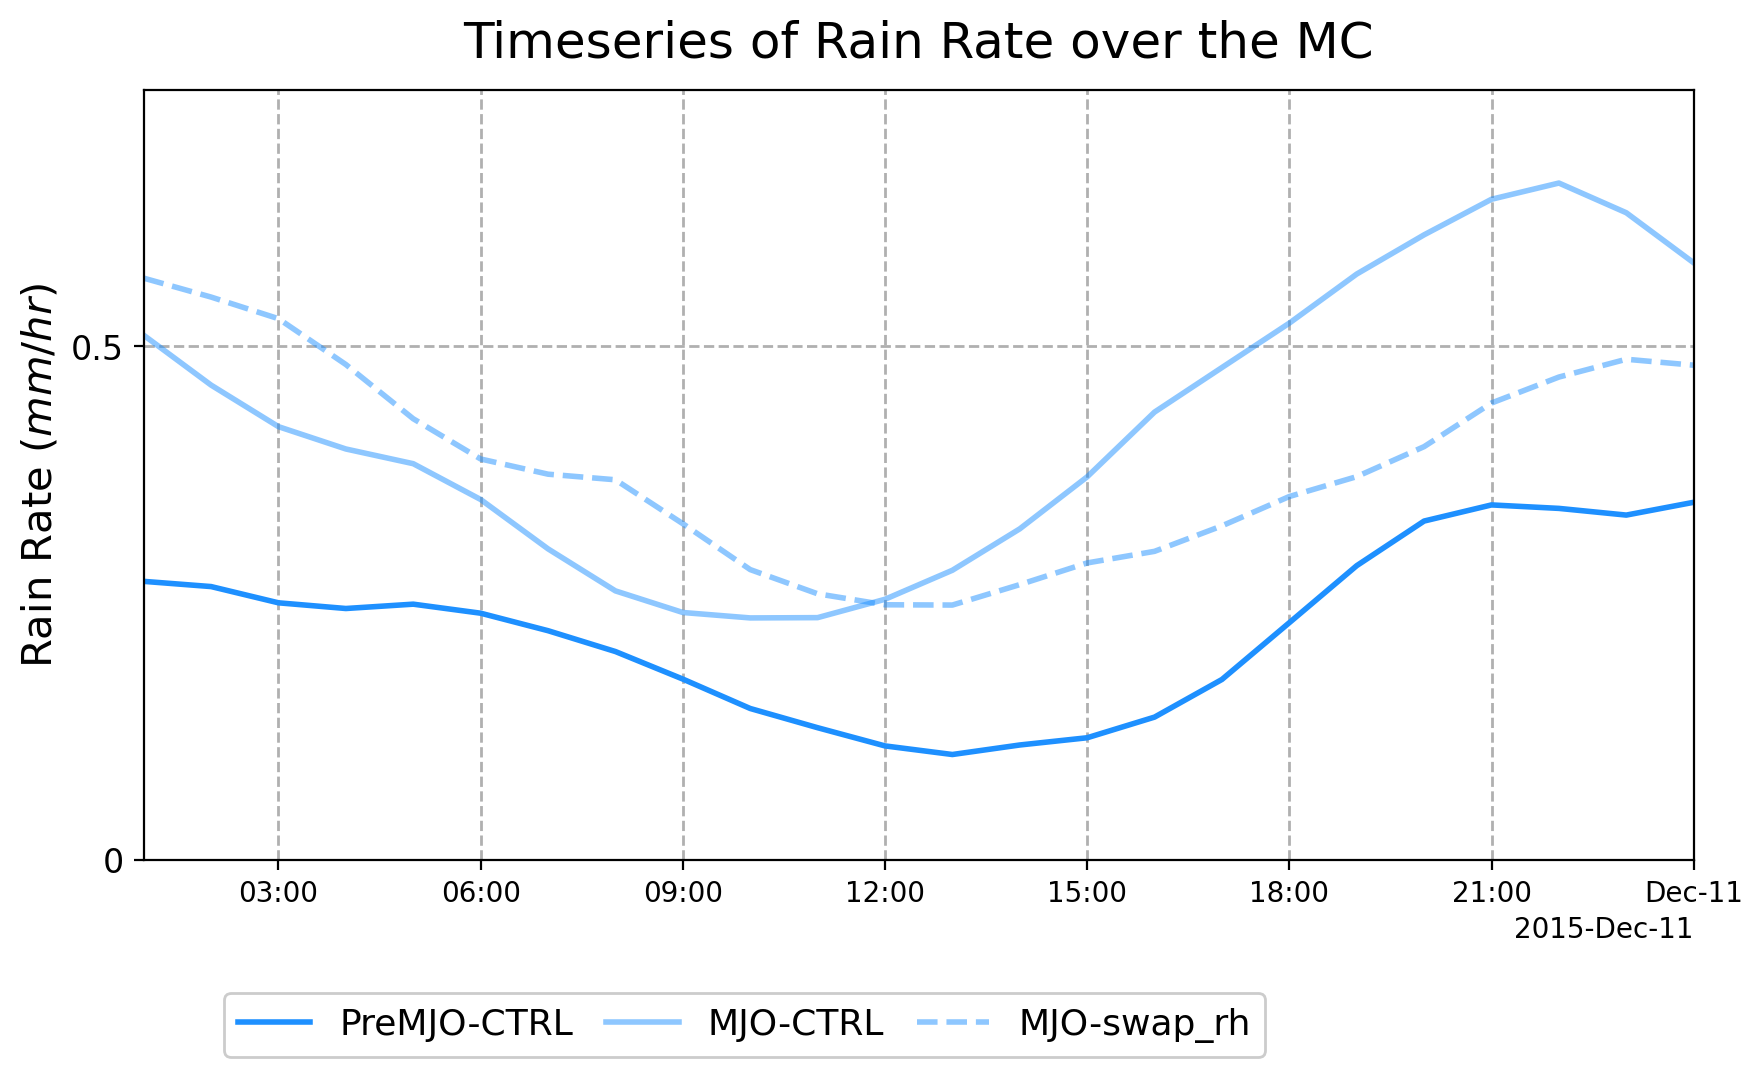

In [37]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=1, ncols=1)

ax1 = fig.add_subplot(gs[0,:])

fs = 18


## PreMJO
# l1 = preMJO_RR_CTRL_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='PreMJO-CTRL'
# )
# l2 = preMJO_RR_di_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )
l3 = preMJO_RR_CTRL_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='PreMJO-CTRL'
)
# l4 = preMJO_RR_hourly_di_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )

## MJO
# l5 = MJO_RR_CTRL_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='MJO-CTRL',
#     alpha=.5
# )
# l6 = MJO_RR_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
l7 = MJO_RR_CTRL_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='MJO-CTRL',
    alpha=.5
)

# l8 = MJO_RR_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
l8 = MJO_RR_swap_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='MJO-swap_rh',
    alpha=.5
)

# ax1.set_yscale('log')
# ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.array([0,0.5,1]))
title = 'Timeseries of Rain Rate over the MC'
ax1.set_title(title, fontsize=fs, y=1.02)
# ax1.set_title(f'[{abs(lat_bound[0])}S, {lat_bound[1]}N]', loc='left', fontsize=fs-10)
ax1.set_xlabel('', fontsize=fs-3)
ax1.set_ylabel('Rain Rate ($mm/hr$)', fontsize=fs-3)
# ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.array(['0','0.5','1']), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=4, fontsize=fs-5, loc='upper left', framealpha=1, columnspacing=.92, bbox_to_anchor=(0.04,-0.15))
ax1.set_xlim([MJO_RR_CTRL_ocean.Time[0],MJO_RR_CTRL_ocean.Time[-1]])
ax1.set_ylim([0,.75])

(0.0, 2.0)

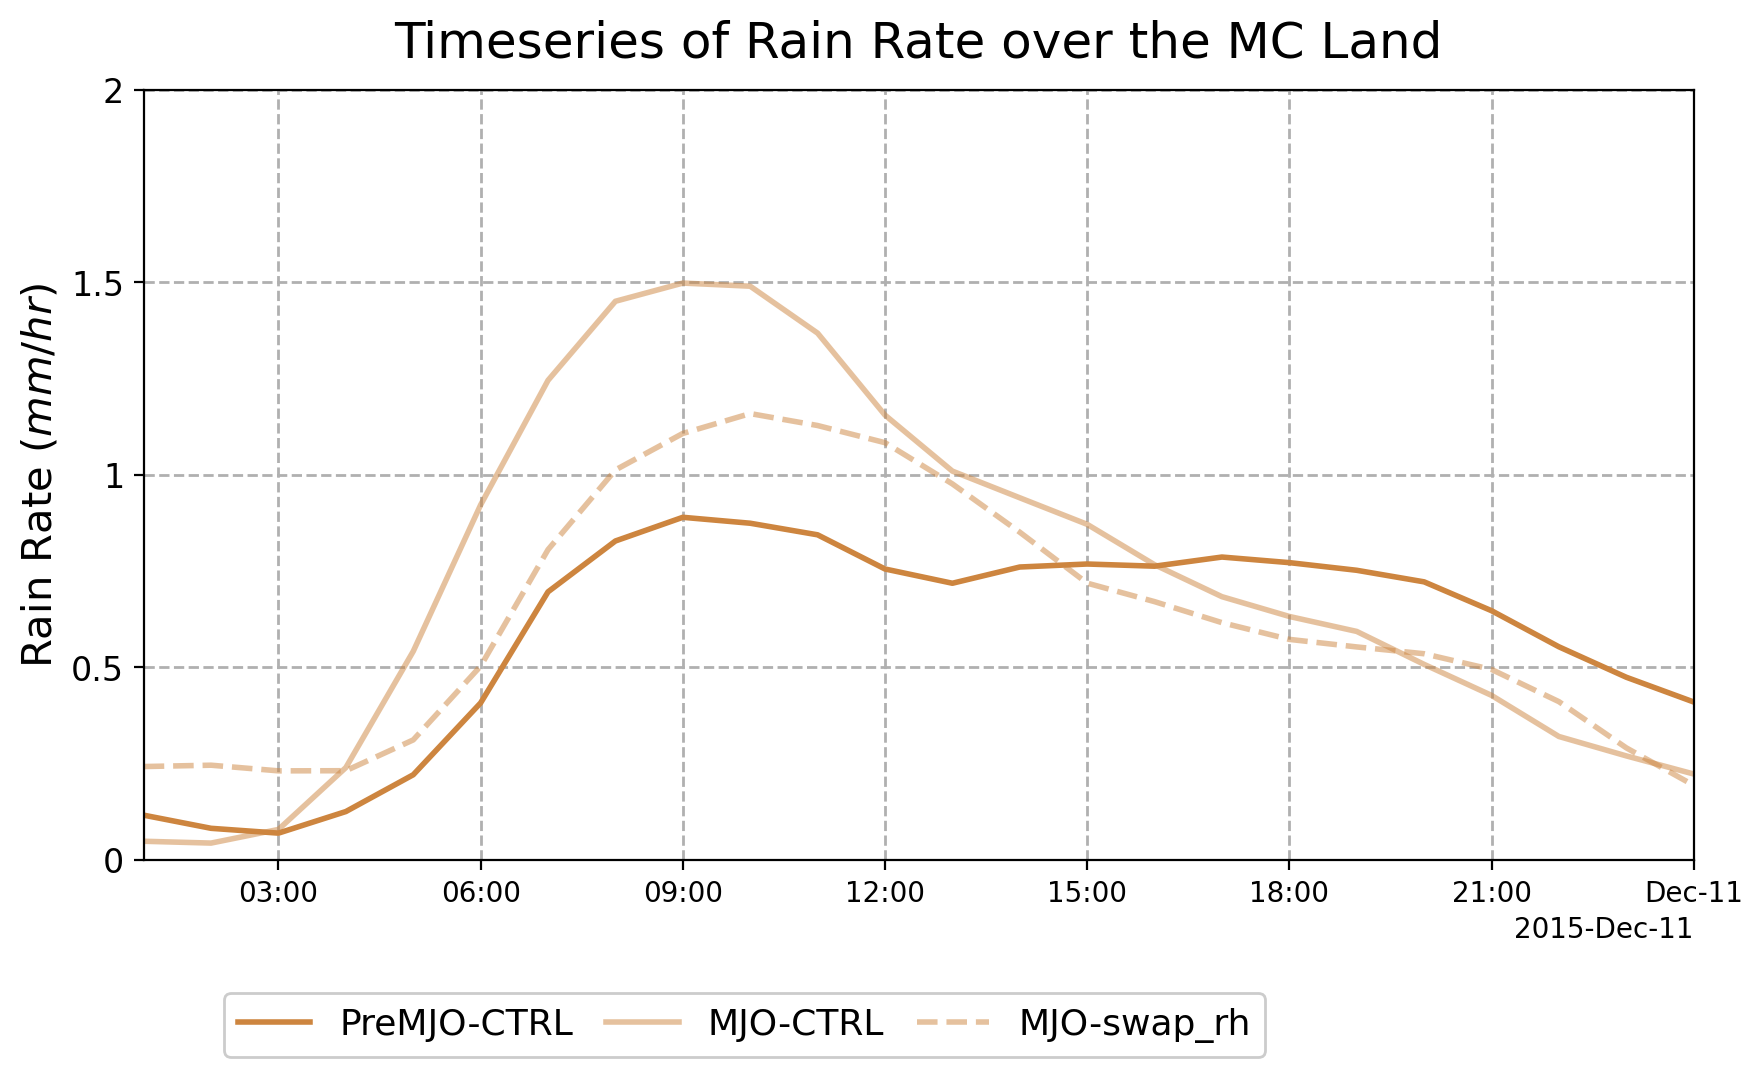

In [64]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=1, ncols=1)

ax1 = fig.add_subplot(gs[0,:])

fs = 18


## PreMJO
l1 = preMJO_RR_CTRL_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='PreMJO-CTRL'
)
# l2 = preMJO_RR_di_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )
# l3 = preMJO_RR_CTRL_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='PreMJO-CTRL'
# )
# l4 = preMJO_RR_hourly_di_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )

## MJO
l5 = MJO_RR_CTRL_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='MJO-CTRL',
    alpha=.5
)
# l6 = MJO_RR_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
# l7 = MJO_RR_CTRL_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='MJO-CTRL',
#     alpha=.5
# )

# l8 = MJO_RR_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
# l9 = MJO_RR_swap_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-swap_rh',
#     alpha=.5
# )
l10 = MJO_RR_swap_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='MJO-swap_rh',
    alpha=.5
)

# ax1.set_yscale('log')
# ax1.set_xticks(np.arange(0,25,3))
ax1.set_yticks(np.array([0,0.5,1,1.5,2]))
title = 'Timeseries of Rain Rate over the MC Land'
ax1.set_title(title, fontsize=fs, y=1.02)
# ax1.set_title(f'[{abs(lat_bound[0])}S, {lat_bound[1]}N]', loc='left', fontsize=fs-10)
ax1.set_xlabel('', fontsize=fs-3)
ax1.set_ylabel('Rain Rate ($mm/hr$)', fontsize=fs-3)
# ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
ax1.set_yticklabels(np.array(['0','0.5','1','1.5','2']), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=4, fontsize=fs-5, loc='upper left', framealpha=1, columnspacing=.92, bbox_to_anchor=(0.04,-0.15))
ax1.set_xlim([MJO_RR_CTRL_ocean.Time[0],MJO_RR_CTRL_ocean.Time[-1]])
ax1.set_ylim([0,2])

##### LH

(80.0, 150.0)

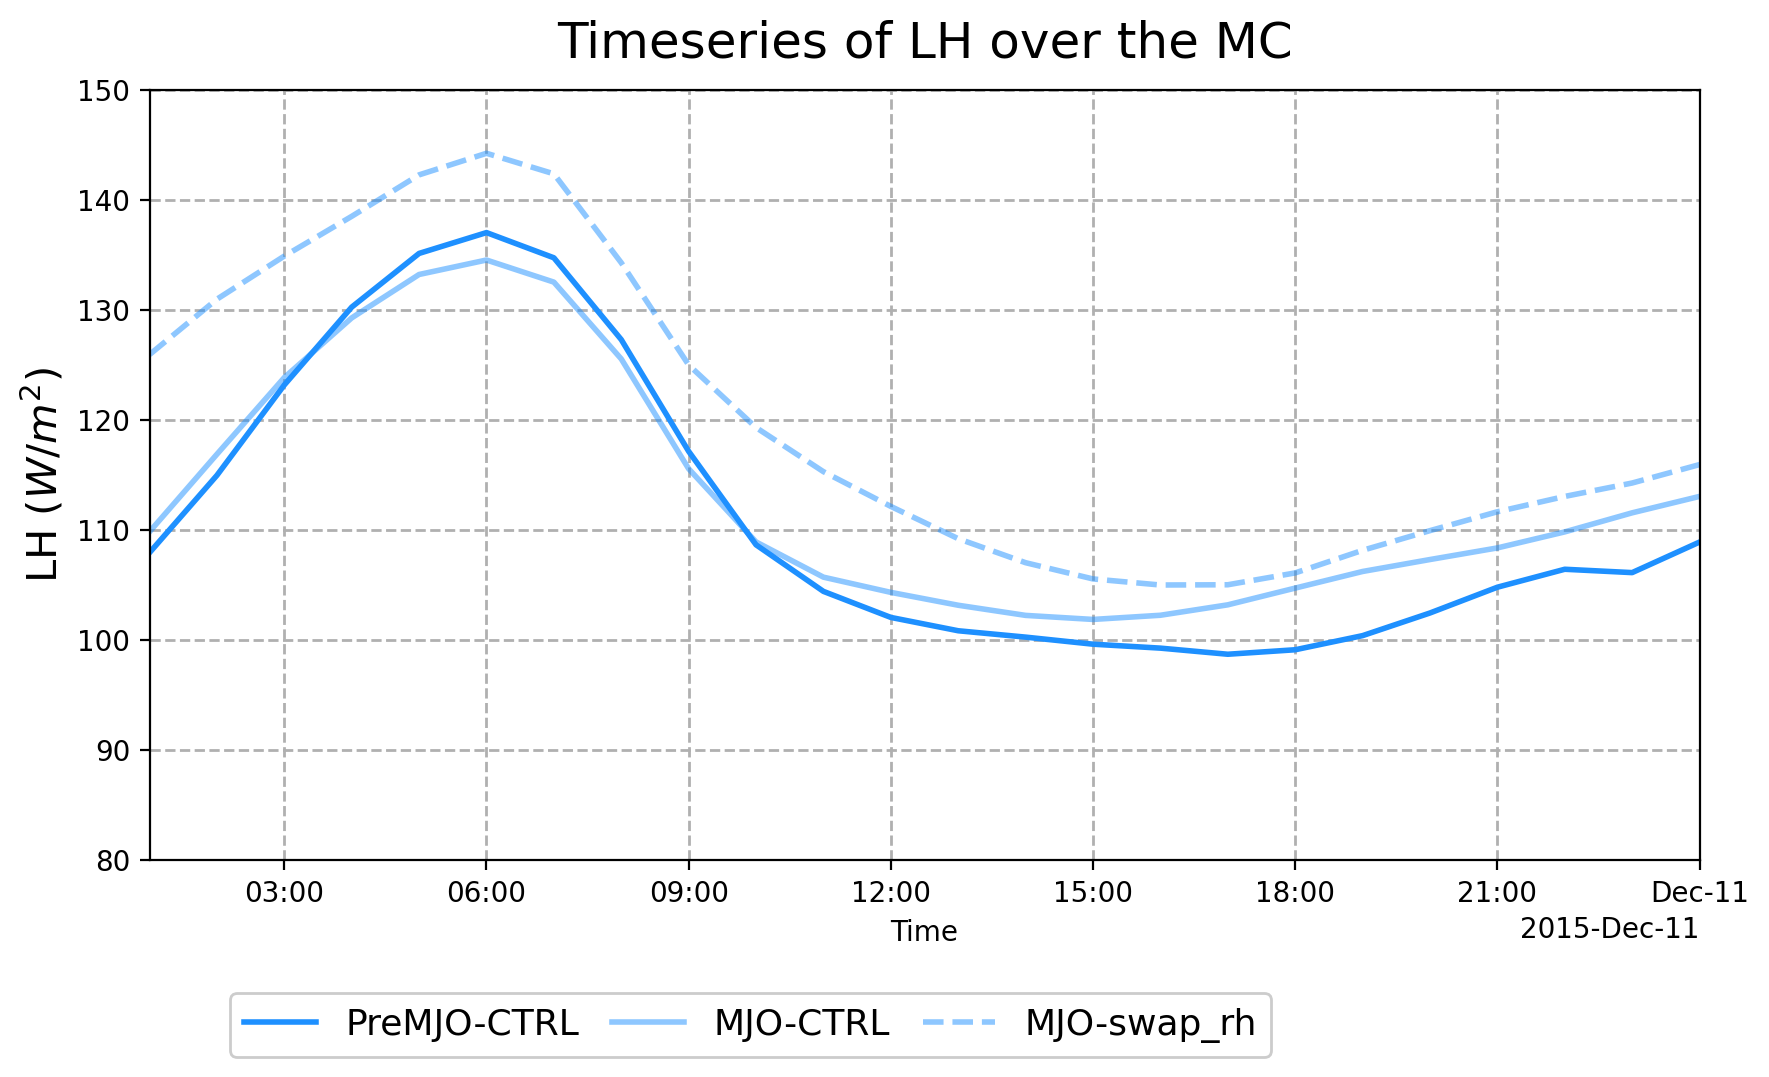

In [60]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=1, ncols=1)

ax1 = fig.add_subplot(gs[0,:])

fs = 18


## PreMJO
# l1 = preMJO_LH_CTRL_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='PreMJO-CTRL'
# )
# l2 = preMJO_LH_di_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )
l3 = preMJO_LH_CTRL_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='PreMJO-CTRL'
)
# l4 = preMJO_LH_hourly_di_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )

## MJO
# l5 = MJO_LH_CTRL_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='MJO-CTRL',
#     alpha=.5
# )
# l6 = MJO_LH_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
l7 = MJO_LH_CTRL_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='MJO-CTRL',
    alpha=.5
)
# l8 = MJO_LH_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
l8 = MJO_LH_swap_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='MJO-swap_rh',
    alpha=.5
)

# ax1.set_yscale('log')
# ax1.set_xticks(np.arange(0,25,3))
# ax1.set_yticks(np.array([0,0.5,1]))
title = 'Timeseries of LH over the MC'
ax1.set_title(title, fontsize=fs, y=1.02)
# ax1.set_title(f'[{abs(lat_bound[0])}S, {lat_bound[1]}N]', loc='left', fontsize=fs-10)
# ax1.set_xlabel('Local Solar Time', fontsize=fs-3)
ax1.set_ylabel('LH ($W/m^{2}$)', fontsize=fs-3)
# ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
# ax1.set_yticklabels(np.array(['0','0.5','1']), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=4, fontsize=fs-5, loc='upper left', framealpha=1, columnspacing=.92, bbox_to_anchor=(0.04,-0.15))
ax1.set_xlim([MJO_LH_CTRL_ocean.Time[0],MJO_LH_CTRL_ocean.Time[-1]])
ax1.set_ylim([80,150])

(16779.041666666668, 16780.0)

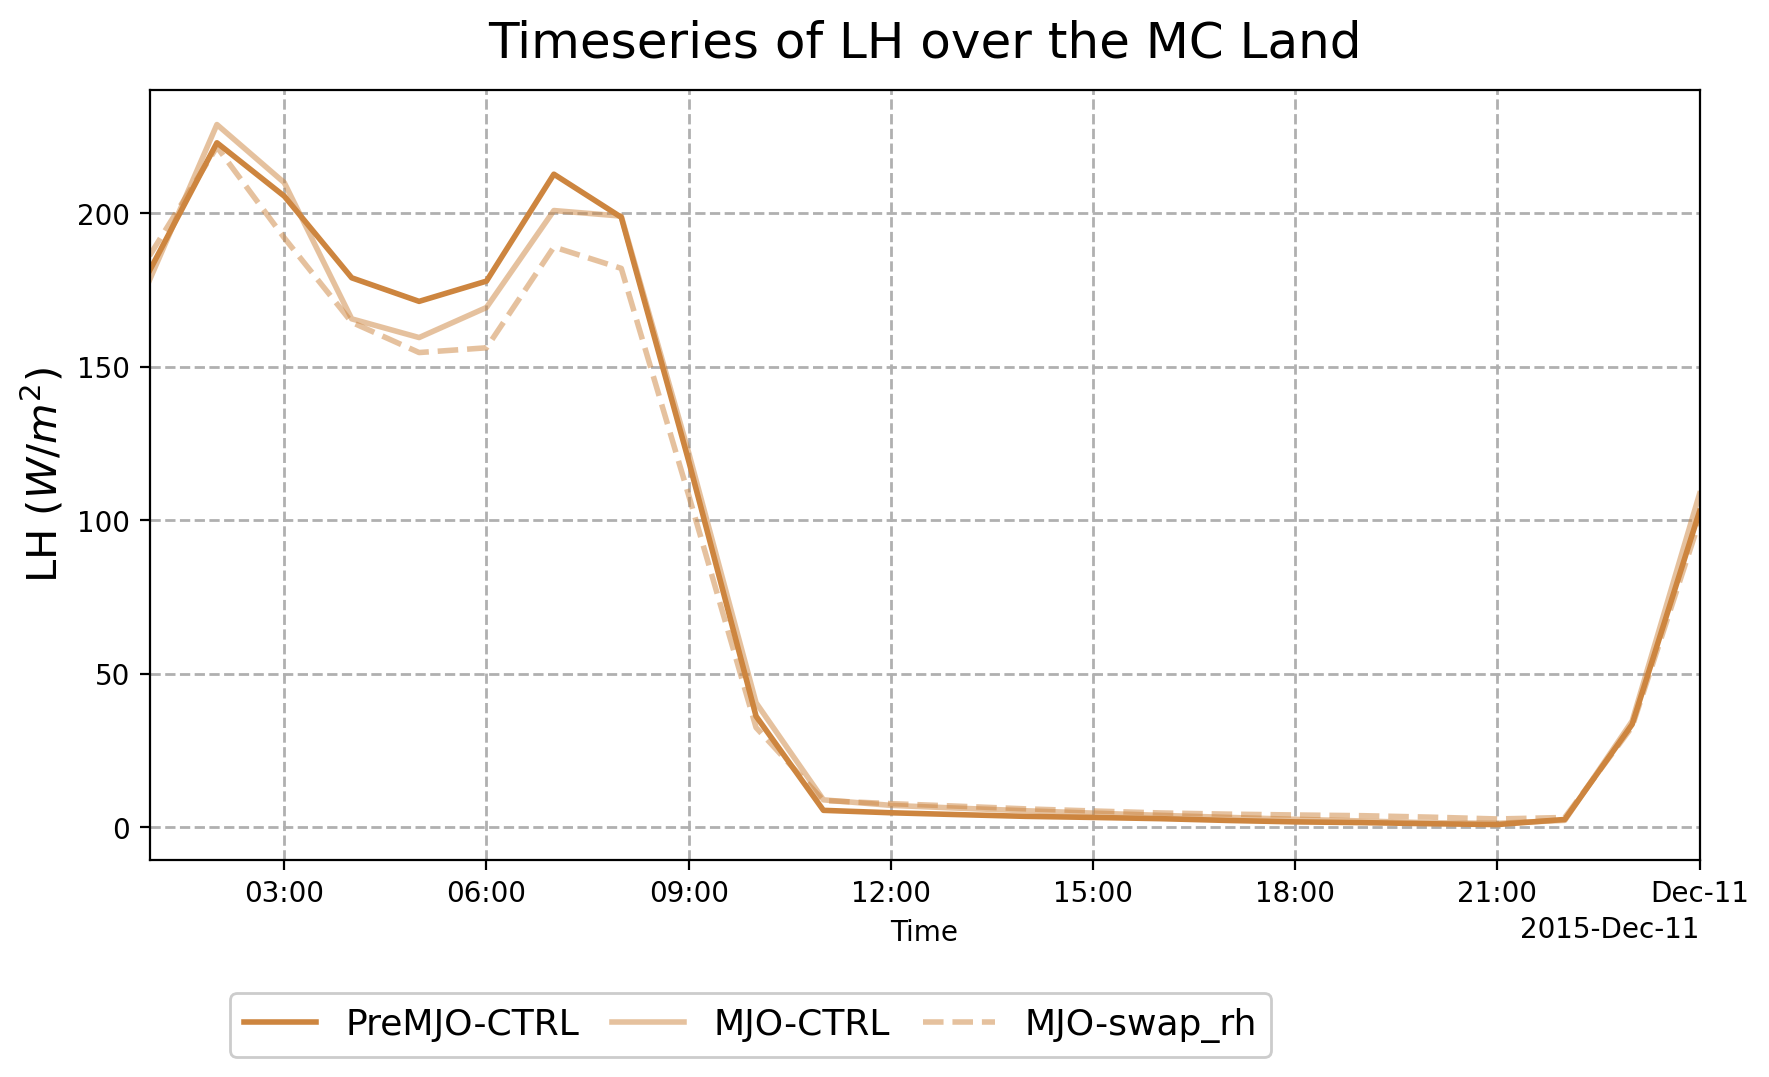

In [66]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=1, ncols=1)

ax1 = fig.add_subplot(gs[0,:])

fs = 18


## PreMJO
l1 = preMJO_LH_CTRL_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='PreMJO-CTRL'
)
# l2 = preMJO_LH_di_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )
# l3 = preMJO_LH_CTRL_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='PreMJO-CTRL'
# )
# l4 = preMJO_LH_hourly_di_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )

## MJO
l5 = MJO_LH_CTRL_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='MJO-CTRL',
    alpha=.5
)
# l6 = MJO_LH_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
# l7 = MJO_LH_CTRL_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='MJO-CTRL',
#     alpha=.5
# )
# l8 = MJO_LH_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
# l9 = MJO_LH_swap_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-swap_rh',
#     alpha=.5
# )
l10 = MJO_LH_swap_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='MJO-swap_rh',
    alpha=.5
)

# ax1.set_yscale('log')
# ax1.set_xticks(np.arange(0,25,3))
# ax1.set_yticks(np.array([0,0.5,1]))
title = 'Timeseries of LH over the MC Land'
ax1.set_title(title, fontsize=fs, y=1.02)
# ax1.set_title(f'[{abs(lat_bound[0])}S, {lat_bound[1]}N]', loc='left', fontsize=fs-10)
# ax1.set_xlabel('Local Solar Time', fontsize=fs-3)
ax1.set_ylabel('LH ($W/m^{2}$)', fontsize=fs-3)
# ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
# ax1.set_yticklabels(np.array(['0','0.5','1']), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=4, fontsize=fs-5, loc='upper left', framealpha=1, columnspacing=.92, bbox_to_anchor=(0.04,-0.15))
ax1.set_xlim([MJO_LH_CTRL_ocean.Time[0],MJO_LH_CTRL_ocean.Time[-1]])
# ax1.set_ylim([80,150])

##### 10-m Windspeed

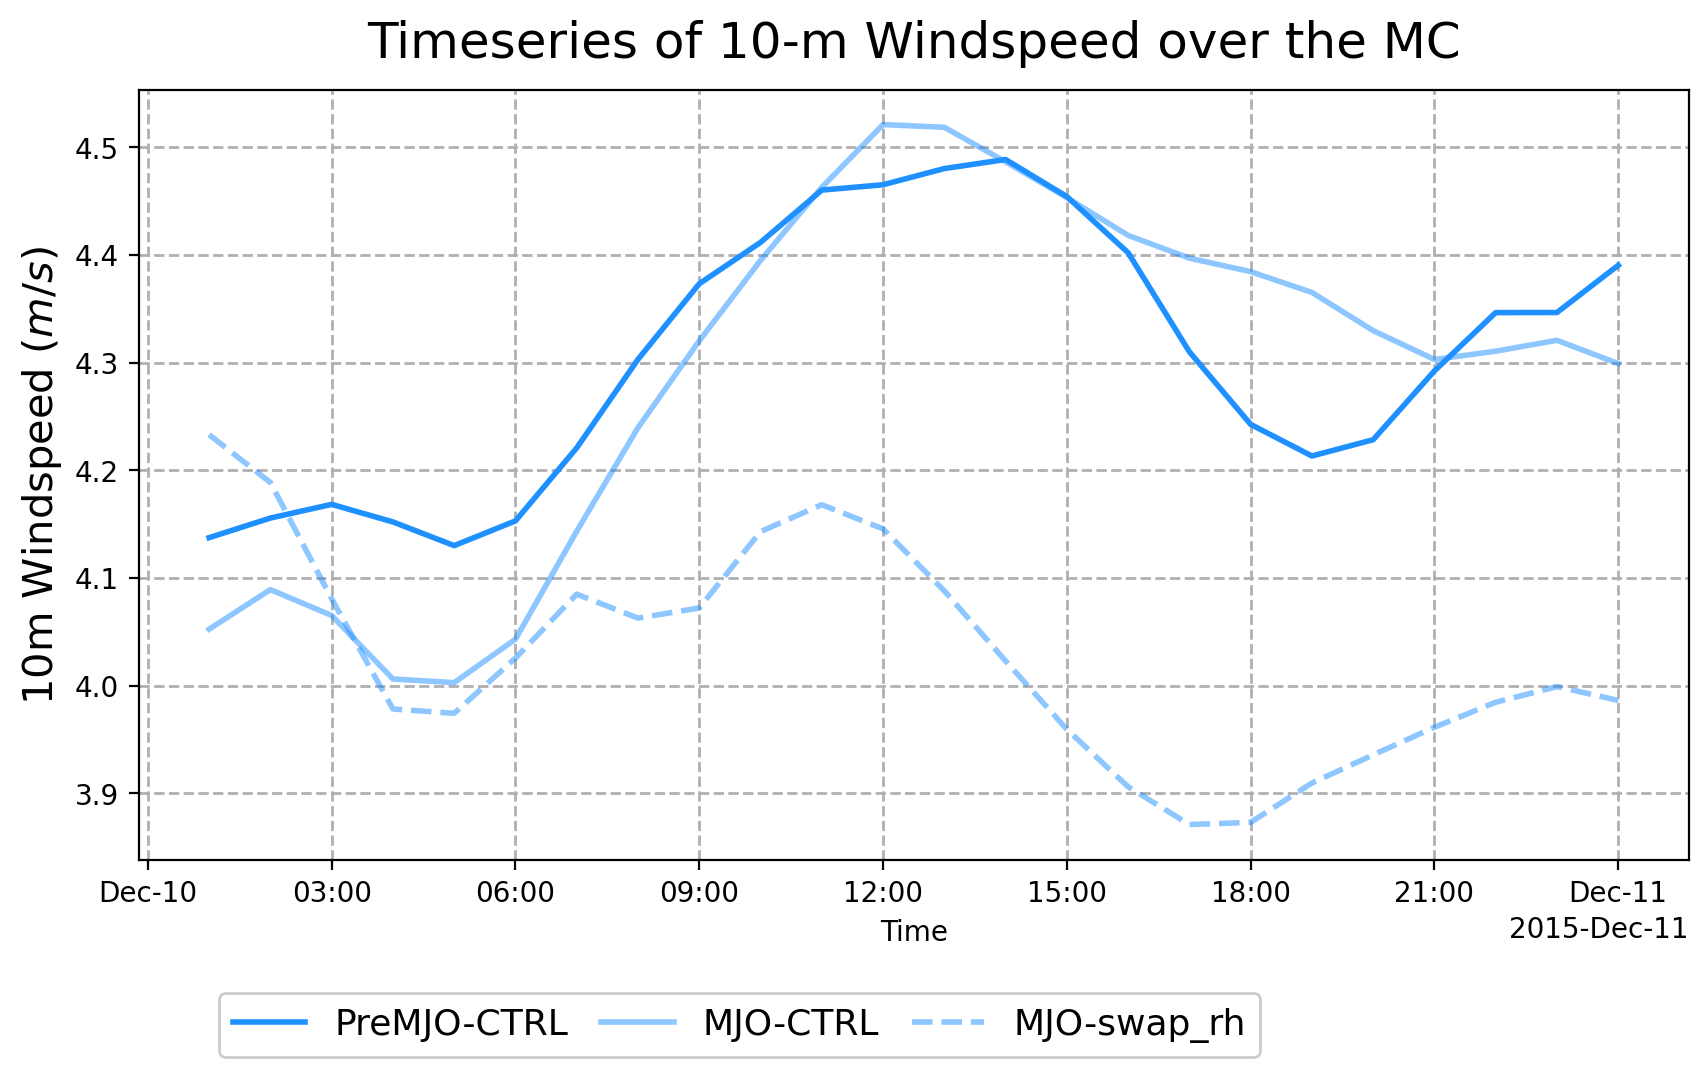

In [55]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=1, ncols=1)

ax1 = fig.add_subplot(gs[0,:])

fs = 18


## PreMJO
# l1 = preMJO_Uwind10_di_ctrl_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='PreMJO-CTRL'
# )
# l2 = preMJO_Uwind10_di_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )
l3 = preMJO_Uwind10_CTRL_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='PreMJO-CTRL'
)
# l4 = preMJO_Uwind10_hourly_di_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )

## MJO
# l5 = MJO_Uwind10_di_ctrl_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='MJO-CTRL',
#     alpha=.5
# )
# l6 = MJO_Uwind10_di_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
l7 = MJO_Uwind10_CTRL_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='MJO-CTRL',
    alpha=.5
)

# l8 = MJO_Uwind10_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
l8 = MJO_Uwind10_swap_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='MJO-swap_rh',
    alpha=.5
)

# ax1.set_yscale('log')
# ax1.set_xticks(np.arange(0,25,3))
# ax1.set_yticks(np.array([0,0.5,1]))
title = 'Timeseries of 10-m Windspeed over the MC'
ax1.set_title(title, fontsize=fs, y=1.02)
# ax1.set_title(f'[{abs(lat_bound[0])}S, {lat_bound[1]}N]', loc='left', fontsize=fs-10)
# ax1.set_xlabel('Local Solar Time', fontsize=fs-3)
ax1.set_ylabel('10m Windspeed ($m/s$)', fontsize=fs-3)
# ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
# ax1.set_yticklabels(np.array(['0','0.5','1']), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=4, fontsize=fs-5, loc='upper left', framealpha=1, columnspacing=.92, bbox_to_anchor=(0.04,-0.15))
# ax1.set_xlim([0,24])
# ax1.set_ylim([0,1])

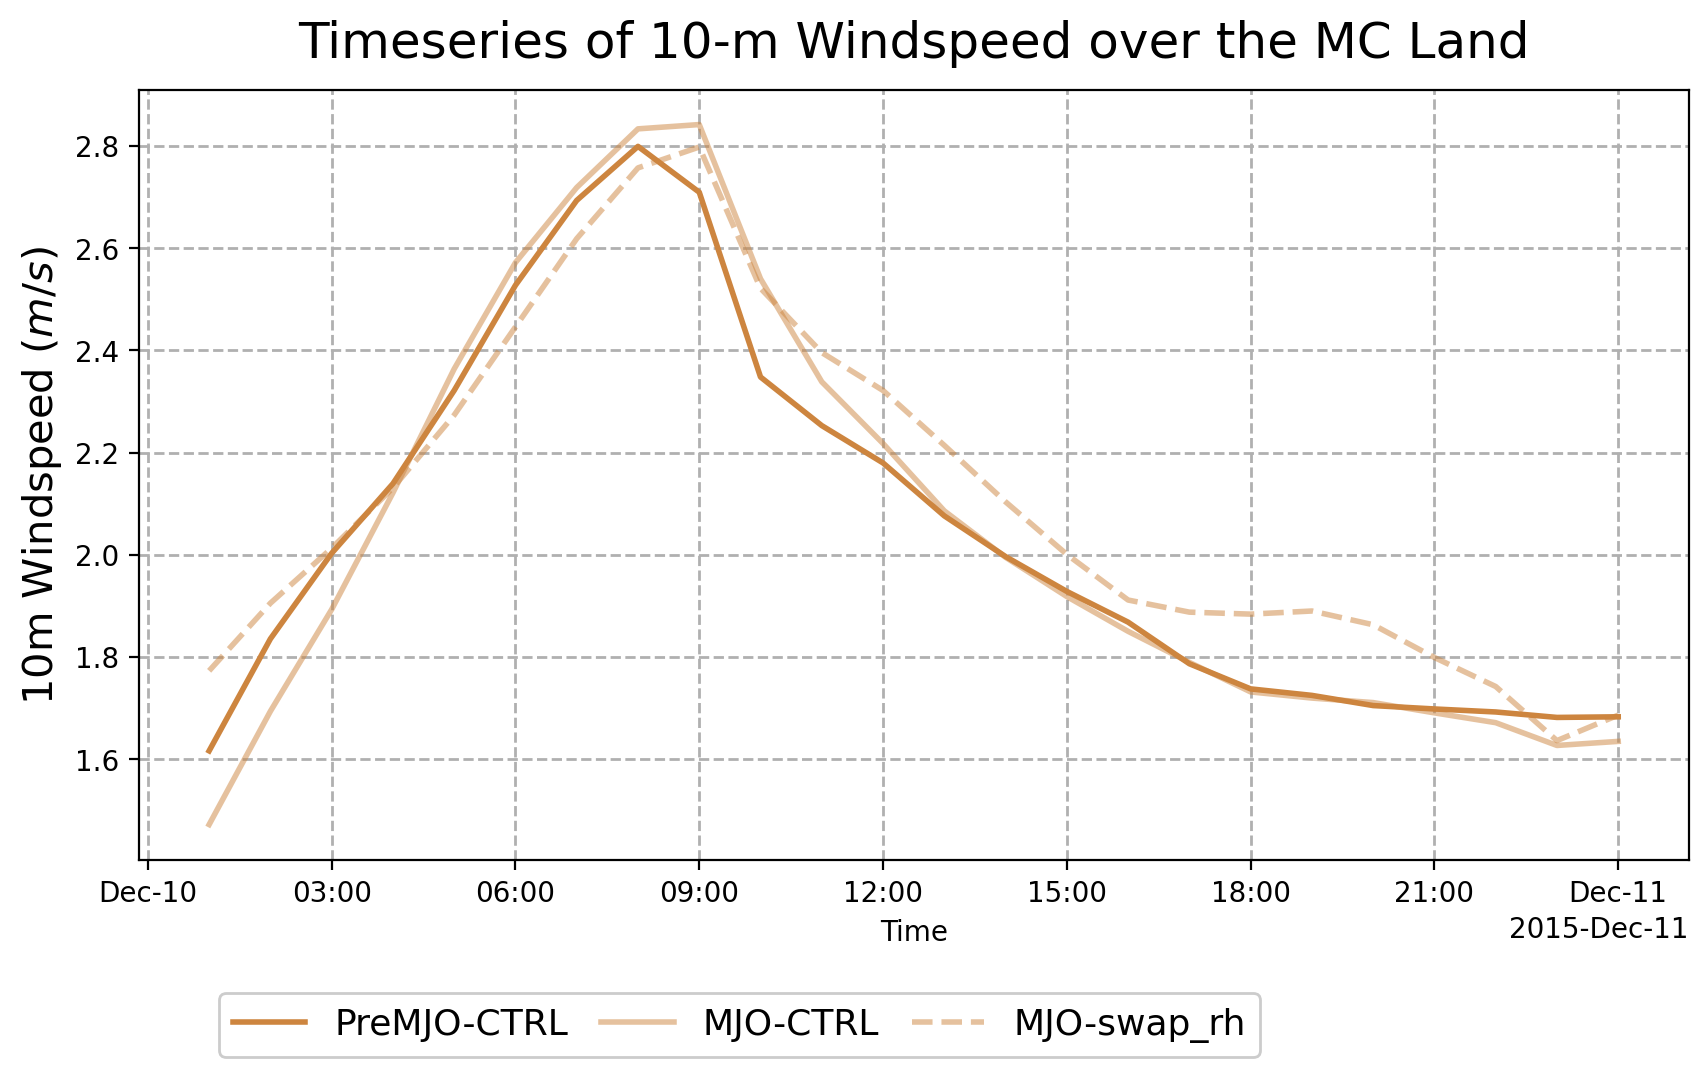

In [67]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=1, ncols=1)

ax1 = fig.add_subplot(gs[0,:])

fs = 18


## PreMJO
l1 = preMJO_Uwind10_CTRL_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='PreMJO-CTRL'
)
# l2 = preMJO_Uwind10_di_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )
# l3 = preMJO_Uwind10_CTRL_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='PreMJO-CTRL'
# )
# l4 = preMJO_Uwind10_hourly_di_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )

## MJO
l5 = MJO_Uwind10_CTRL_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '-',
	label='MJO-CTRL',
    alpha=.5
)
# l6 = MJO_Uwind10_di_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
# l7 = MJO_Uwind10_CTRL_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '-',
# 	label='MJO-CTRL',
#     alpha=.5
# )

# l8 = MJO_Uwind10_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
# l8 = MJO_Uwind10_swap_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-swap_rh',
#     alpha=.5
# )
l8 = MJO_Uwind10_swap_land.plot.line(
    ax=ax1,
    color='peru',
    linewidth=2,
    linestyle = '--',
	label='MJO-swap_rh',
    alpha=.5
)

# ax1.set_yscale('log')
# ax1.set_xticks(np.arange(0,25,3))
# ax1.set_yticks(np.array([0,0.5,1]))
title = 'Timeseries of 10-m Windspeed over the MC Land'
ax1.set_title(title, fontsize=fs, y=1.02)
# ax1.set_title(f'[{abs(lat_bound[0])}S, {lat_bound[1]}N]', loc='left', fontsize=fs-10)
# ax1.set_xlabel('Local Solar Time', fontsize=fs-3)
ax1.set_ylabel('10m Windspeed ($m/s$)', fontsize=fs-3)
# ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
# ax1.set_yticklabels(np.array(['0','0.5','1']), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=4, fontsize=fs-5, loc='upper left', framealpha=1, columnspacing=.92, bbox_to_anchor=(0.04,-0.15))
# ax1.set_xlim([0,24])
# ax1.set_ylim([0,1])

##### VI-QV 1000-100 hPa

(16779.041666666668, 16780.0)

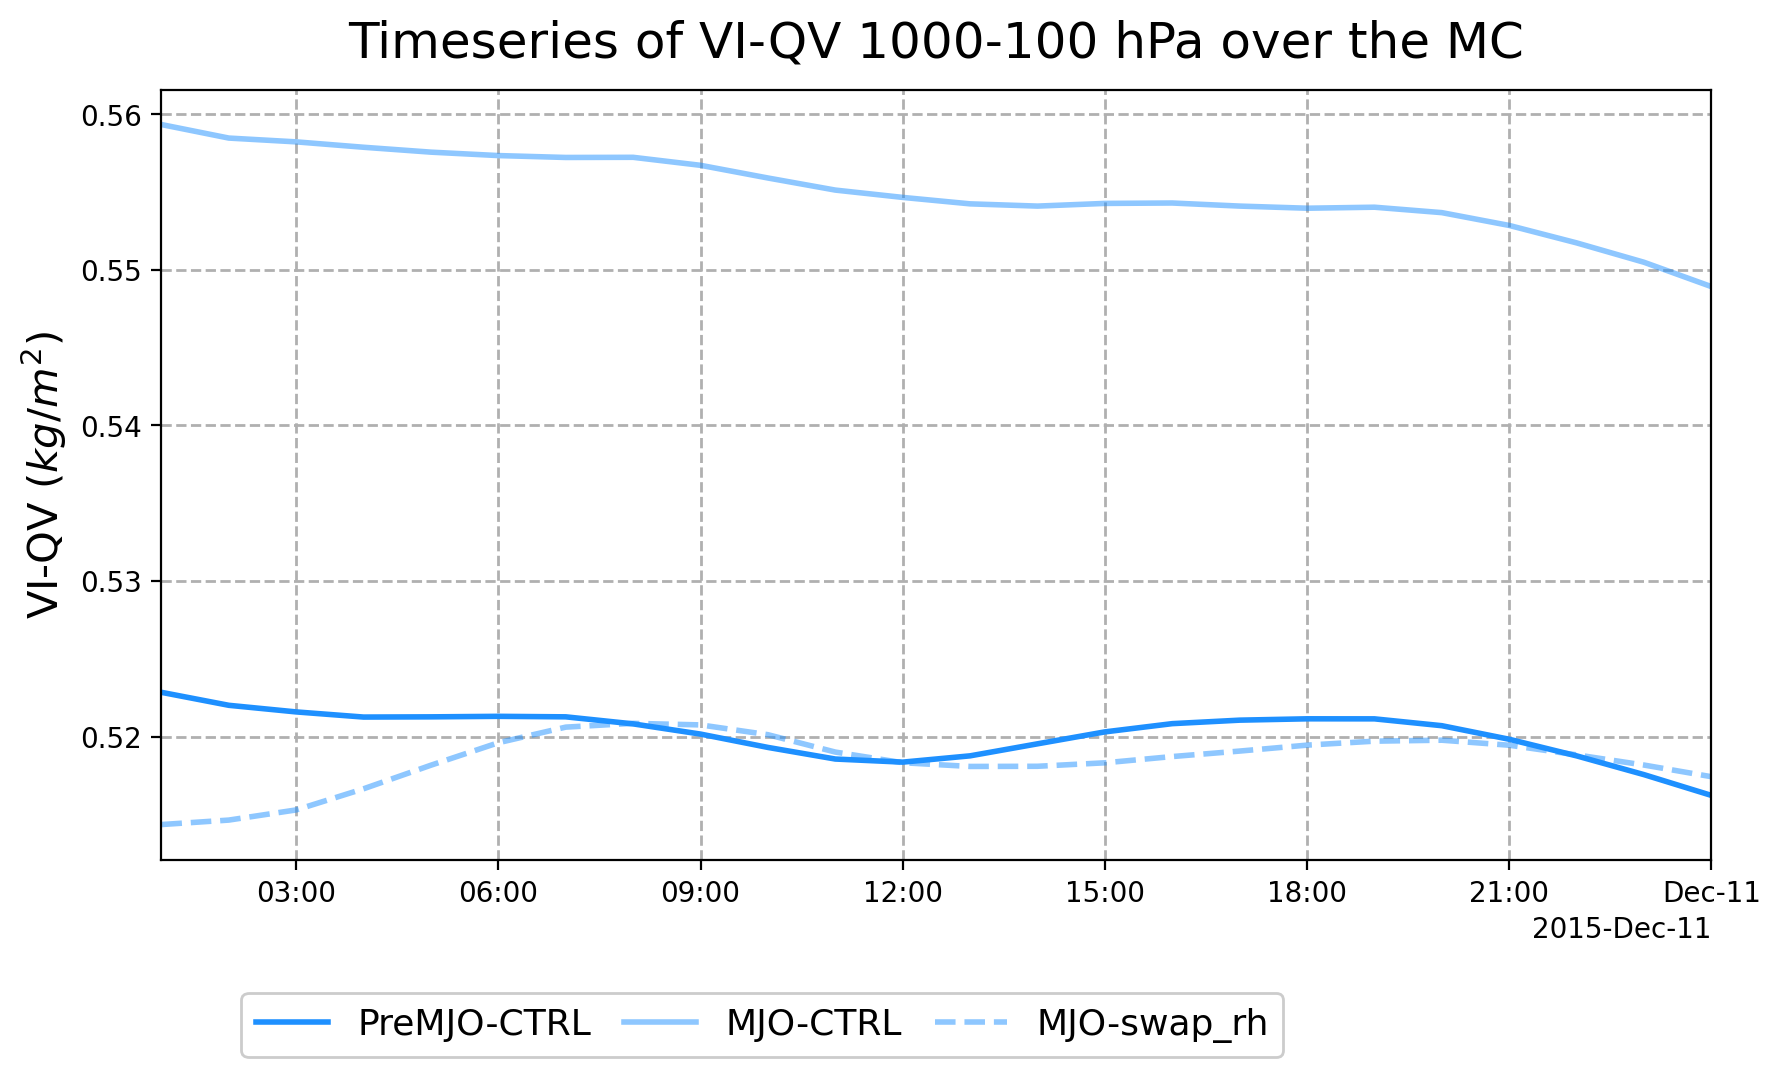

In [45]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(nrows=1, ncols=1)

ax1 = fig.add_subplot(gs[0,:])

fs = 18


## PreMJO
# l1 = preMJO_VI_QV_1000_100_CTRL_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='PreMJO-CTRL'
# )
# l2 = preMJO_VI_QV_1000_100_di_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )
l3 = preMJO_VI_QV_1000_100_CTRL_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='PreMJO-CTRL'
)
# l4 = preMJO_VI_QV_1000_100_hourly_di_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='PreMJO-adjLH'
# )

## MJO
# l5 = MJO_VI_QV_1000_100_CTRL_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '-',
# 	label='MJO-CTRL',
#     alpha=.5
# )
# l6 = MJO_VI_QV_1000_100_adjLH_land.plot.line(
#     ax=ax1,
#     color='peru',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
l7 = MJO_VI_QV_1000_100_CTRL_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '-',
	label='MJO-CTRL',
    alpha=.5
)

# l8 = MJO_VI_QV_1000_100_adjLH_ocean.plot.line(
#     ax=ax1,
#     color='dodgerblue',
#     linewidth=2,
#     linestyle = '--',
# 	label='MJO-adjLH',
#     alpha=.5
# )
l8 = MJO_VI_QV_1000_100_swap_ocean.plot.line(
    ax=ax1,
    color='dodgerblue',
    linewidth=2,
    linestyle = '--',
	label='MJO-swap_rh',
    alpha=.5
)

# ax1.set_yscale('log')
# ax1.set_xticks(np.arange(0,25,3))
# ax1.set_yticks(np.array([0,0.5,1]))
title = 'Timeseries of VI-QV 1000-100 hPa over the MC'
ax1.set_title(title, fontsize=fs, y=1.02)
# ax1.set_title(f'[{abs(lat_bound[0])}S, {lat_bound[1]}N]', loc='left', fontsize=fs-10)
ax1.set_xlabel('', fontsize=fs-3)
ax1.set_ylabel('VI-QV ($kg/m^{2}$)', fontsize=fs-3)
# ax1.set_xticklabels(np.concatenate((np.arange(0,24,3),[0])), fontsize=fs-6)
# ax1.set_yticklabels(np.array(['0','0.5','1']), fontsize=fs-6)
ax1.grid(linestyle='--', axis='x', linewidth=1)
ax1.grid(linestyle='--', axis='y', linewidth=1)
ax1.legend(ncol=4, fontsize=fs-5, loc='upper left', framealpha=1, columnspacing=.92, bbox_to_anchor=(0.04,-0.15))
ax1.set_xlim([MJO_VI_QV_1000_100_CTRL_ocean.Time[0],MJO_VI_QV_1000_100_CTRL_ocean.Time[-1]])
# ax1.set_ylim([0,.75])